# Analysis of Foursquare Data Using Kmeans Clustering

In [1]:
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%matplotlib inline
#import statsmodels.formula.api as smf
import itertools
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.metrics import silhouette_score
# from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
import pandas as pd
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage  # for hierarchical clustering
from scipy.cluster.hierarchy import fcluster
# from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
import pandas as pd
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage  # for hierarchical clustering
from scipy.cluster.hierarchy import fcluster
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [2]:
data = gpd.read_file('NYU_March2018_subset30.geojson')

In [3]:
(list(data.columns))
len(data)
data.head(2)

,id,Place Name,Rating,Checkins,Users,Visits,Pricing,Type,Category,Class,geometry
0,50ad0afce4b0b4a7430e2268,Terry's Wine Shop,8.8,294,217,337,None,Wine Shop,Consumption,Optional,POINT (-74.00034036700906 40.73518392010902)
1,4dc81f74887717c88063848e,ATSJ Food Corp. Deli & Grill,NaN,234,16,234,1,Deli / Bodega,Nutrition,Necessary,POINT (-73.90894204163702 40.75747367718153)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


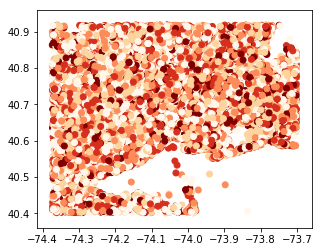

In [4]:
ax = data.plot(column='Checkins', scheme='quantiles', cmap='OrRd')

In [5]:
maps=gpd.read_file('Censustracts/total.shp')

In [6]:
maps['GEOID'].unique()

array([36061007100, 36081016300, 36061003200, ..., 34013011800,
       34013000400, 36081005000])

In [7]:
len(maps['GEOID'].unique())

1747

In [8]:
maps['Type_1.19'].unique()

array(['MHI - Ongoing Exclusion', 'LI - At Risk of Gentrification',
       'MHI - Advanced Gentrification',
       'MHI - Stable or Early Stage of Exclusion', 'Missing Data',
       'LI - Ongoing Gentrification', 'MHI - Advanced Exclusion',
       'VHI - Super Gentrification or Exclusion',
       'LI - Ongoing Displacement of Low-Income Households',
       'LI - Not Losing Low-Income Households'], dtype=object)

In [9]:
maps['Type_1.19'][maps['Type_1.19']==7]
#455,516

Series([], Name: Type_1.19, dtype: object)

In [10]:
maps.shape

(7431, 107)

In [11]:
print(list(maps.columns))

['id', 'Place Name', 'Rating', 'Checkins', 'Users', 'Visits', 'Pricing', 'Type', 'Category', 'Class', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND', 'AWATER', 'geo', 'GEOid2', 'hh16', 'moe_hh16', 'per_col00', 'per_nonwhi', 'per_rent00', 'vli2000', 'li2000', 'mi2000', 'hmi2000', 'hi2000', 'vhi2000', 'per_all_li', 'hh00', 'all_li_cou', 'per_nonw_1', 'per_rent90', 'vli1990', 'li1990', 'mi1990', 'hmi1990', 'hi1990', 'vhi1990', 'denominato', 'per_all__1', 'all_li_c_1', 'pop00', 'pop16', 'moe_pop16', 'ch_all_li_', 'ch_all_li1', 'moveinincd', 'co_med_ind', 'per_limove', 'per_limo_1', 'TOD', 'empd15', 'mrent90', 'rou90', 'mrent00', 'rou00', 'mrent16', 'moe_mrent1', 'mhval90', 'ohu90', 'mhval00', 'ohu00', 'mhval16', 'moe_mhval1', 'mhval90_00', 'mhval00_16', 'mrent90_00', 'mrent00_16', 'hu16', 'per_units_', 'ohu16', 'moe_owner1', 'rhu16', 'moe_renter', 'per_rent16', 'per_nonw_2', 'vli2016', 'li2016', 'mi2016', 'hmi2016', 'hi2016', 'vhi2016', 'per_all__2', 'all_li

In [12]:
types = maps.groupby('Type').count()[['id']].sort_values(ascending = False, by='id')

In [13]:
len(types)

142

In [14]:
category = maps.groupby('Category').count()[['id']].sort_values(ascending = False, by='id')

In [15]:
category.head()

,id
Category,
Social,4837
Nutrition,1884
Consumption,701
Leisure,9


In [16]:
plt.rcParams['figure.figsize'] = (30, 20)


In [17]:
maps

,id,Place Name,Rating,Checkins,Users,Visits,Pricing,Type,Category,Class,...,moe_doctor,per_col_16,pop90,per_col90,moe_hu16,hinc16,moe_hinc16,popgrowth,Type_1.19,geometry
0,3fd66200f964a5202bea1ee3,Bar Six,7.5,7129.0,4556.0,7886.0,2.0,French Restaurant,Social,Optional,...,103,0.772135,6241.000000,0.594715,63,127904,11686,418.000000,MHI - Ongoing Exclusion,"POLYGON ((983477.0537245736 206553.0512004816,..."
1,3fd66200f964a520abe51ee3,Fiddlesticks Pub & Grill,6.1,23722.0,18806.0,28049.0,2.0,Bar,Social,Optional,...,103,0.772135,6241.000000,0.594715,63,127904,11686,418.000000,MHI - Ongoing Exclusion,"POLYGON ((983477.0537245736 206553.0512004816,..."
2,3fd66200f964a520d0e51ee3,Spain Restaurant,7.1,2095.0,2596.0,3949.0,1.0,Tapas Restaurant,Social,Optional,...,103,0.772135,6241.000000,0.594715,63,127904,11686,418.000000,MHI - Ongoing Exclusion,"POLYGON ((983477.0537245736 206553.0512004816,..."
3,3fd66200f964a520f2e61ee3,The Monster,7.8,10191.0,7352.0,14328.0,1.0,Gay Bar,Social,Optional,...,103,0.772135,6241.000000,0.594715,63,127904,11686,418.000000,MHI - Ongoing Exclusion,"POLYGON ((983477.0537245736 206553.0512004816,..."
4,4388f700f964a520182b1fe3,Joe,8.8,17312.0,9611.0,23679.0,1.0,Coffee Shop,Social,Optional,...,103,0.772135,6241.000000,0.594715,63,127904,11686,418.000000,MHI - Ongoing Exclusion,"POLYGON ((983477.0537245736 206553.0512004816,..."
5,49c266a1f964a520e9551fe3,Patisserie Claude,7.6,1364.0,783.0,1424.0,1.0,Bakery,Nutrition,Necessary,...,103,0.772135,6241.000000,0.594715,63,127904,11686,418.000000,MHI - Ongoing Exclusion,"POLYGON ((983477.0537245736 206553.0512004816,..."
6,49cd07cdf964a520ab591fe3,Gottino Enoteca Salumeria,9.0,7004.0,5219.0,8322.0,3.0,Wine Bar,Social,Optional,...,103,0.772135,6241.000000,0.594715,63,127904,11686,418.000000,MHI - Ongoing Exclusion,"POLYGON ((983477.0537245736 206553.0512004816,..."
7,4a78c865f964a52068e61fe3,Joseph Leonard,9.4,17804.0,14305.0,25861.0,3.0,New American Restaurant,Social,Optional,...,103,0.772135,6241.000000,0.594715,63,127904,11686,418.000000,MHI - Ongoing Exclusion,"POLYGON ((983477.0537245736 206553.0512004816,..."
8,4e974e33be7ba85e57dd0884,Onegin Restaurant,7.9,3429.0,3644.0,5060.0,3.0,Russian Restaurant,Social,Optional,...,103,0.772135,6241.000000,0.594715,63,127904,11686,418.000000,MHI - Ongoing Exclusion,"POLYGON ((983477.0537245736 206553.0512004816,..."
9,540b96a9498e77fa82499dad,Shu Han Ju Chinese Restaurant,7.3,449.0,476.0,722.0,1.0,Chinese Restaurant,Social,Optional,...,103,0.772135,6241.000000,0.594715,63,127904,11686,418.000000,MHI - Ongoing Exclusion,"POLYGON ((983477.0537245736 206553.0512004816,..."


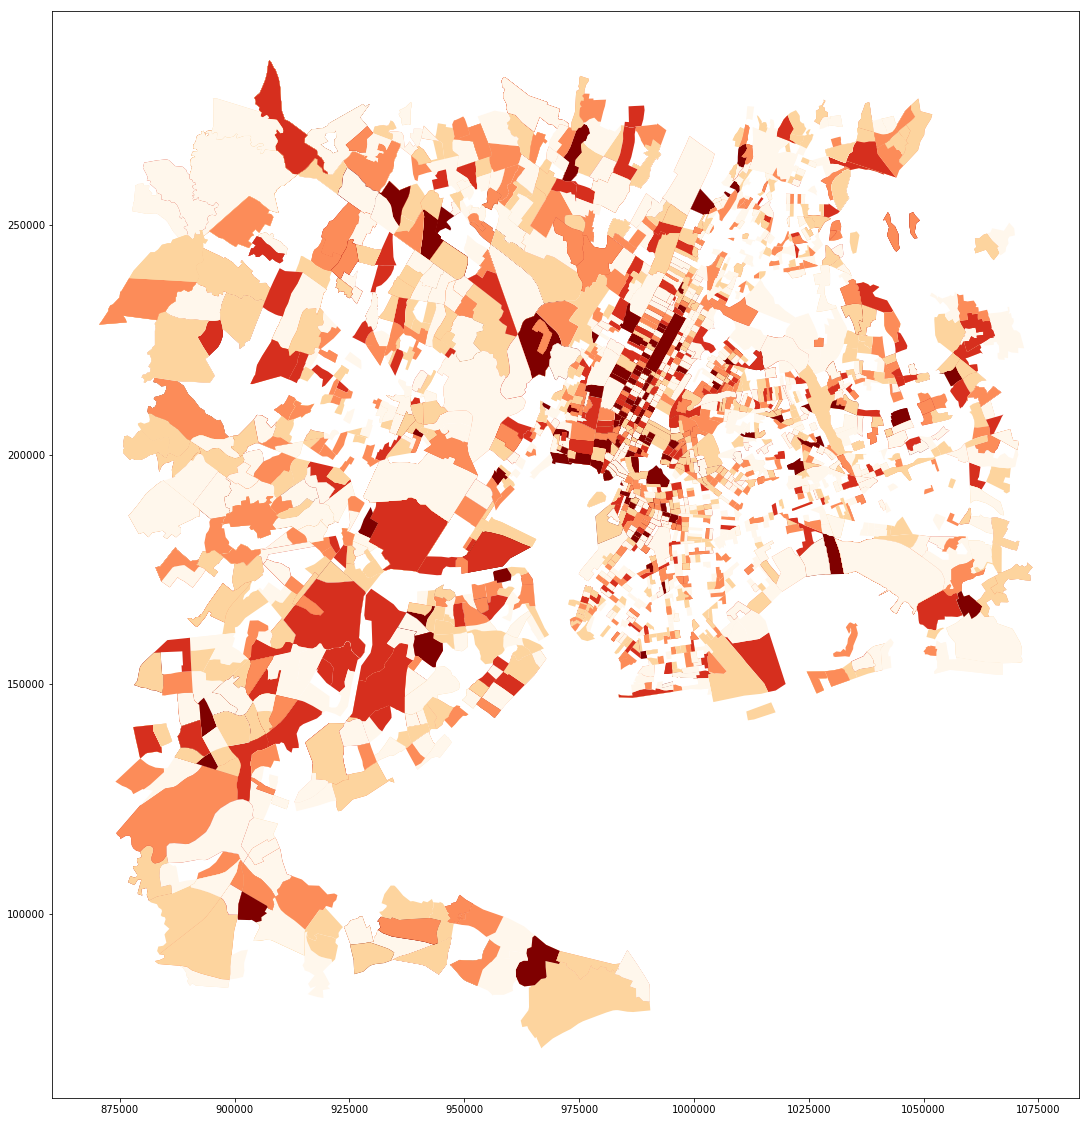

In [18]:
ax = maps.plot(column='Checkins', scheme='quantiles', cmap='OrRd')

In [19]:
print(maps.iloc[:,2:10].shape)
maps.iloc[:,2:10].dropna().shape

(7431, 8)


(7431, 8)

#  Clustering

## 1. Cluster by Foursquare attributes

In [20]:
X = maps.iloc[:,2:10]
X.iloc[:,5:8].columns
for column in X.iloc[:,5:8].columns:
    print(column)
    X[column] = pd.factorize(X[column])[0]
X.head(10)


Type
Category
Class


,Rating,Checkins,Users,Visits,Pricing,Type,Category,Class
0,7.5,7129.0,4556.0,7886.0,2.0,0,0,0
1,6.1,23722.0,18806.0,28049.0,2.0,1,0,0
2,7.1,2095.0,2596.0,3949.0,1.0,2,0,0
3,7.8,10191.0,7352.0,14328.0,1.0,3,0,0
4,8.8,17312.0,9611.0,23679.0,1.0,4,0,0
5,7.6,1364.0,783.0,1424.0,1.0,5,1,1
6,9.0,7004.0,5219.0,8322.0,3.0,6,0,0
7,9.4,17804.0,14305.0,25861.0,3.0,7,0,0
8,7.9,3429.0,3644.0,5060.0,3.0,8,0,0
9,7.3,449.0,476.0,722.0,1.0,9,0,0


# 2. Clustering by Census 

In [21]:
# vli	li	mi	mhi	hi	vhi	hinc	vli_mig	li_mig	mi_mig	mhi_mig	per_all_li_mig

income_columns = []

income_columns = ['hinc16','pop16']

In [22]:
print(maps.shape)
maps= maps.replace(0,np.nan)
maps=maps.dropna(how='all',axis=0)
print(maps.shape)

(7431, 107)
(7431, 107)


In [23]:
maps.isnull().sum().sum()

23513

In [24]:
# maps = maps[~(maps[income_columns] == 0).any(axis=1)]
print(maps.shape)

(7431, 107)


In [25]:
print(maps[income_columns].shape)
maps[income_columns].dropna().shape
print(maps[income_columns].dropna().shape)

(7431, 2)
(7294, 2)


In [26]:
Foursquare = maps.iloc[:,2:10]
Foursquare.iloc[:,5:8].columns

Index(['Type', 'Category', 'Class'], dtype='object')

In [27]:
income_columns+['GEOID']+list(Foursquare.columns)

['hinc16',
 'pop16',
 'GEOID',
 'Rating',
 'Checkins',
 'Users',
 'Visits',
 'Pricing',
 'Type',
 'Category',
 'Class']

In [28]:
X_geoID_dummies = maps[income_columns+['GEOID']+list(Foursquare.columns)].dropna()
print(X_geoID_dummies.shape)
X_geoID_dummies = pd.get_dummies(X_geoID_dummies)
X_geoID_dummies.head()

(7294, 11)


,hinc16,pop16,GEOID,Rating,Checkins,Users,Visits,Pricing,Type_Afghan Restaurant,Type_African Restaurant,...,Type_Vietnamese Restaurant,Type_Whisky Bar,Type_Wine Bar,Type_Wings Joint,Category_Consumption,Category_Leisure,Category_Nutrition,Category_Social,Class_Necessary,Class_Optional
0,127904.0,6038.0,36061007100,7.5,7129.0,4556.0,7886.0,2.0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,127904.0,6038.0,36061007100,6.1,23722.0,18806.0,28049.0,2.0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,127904.0,6038.0,36061007100,7.1,2095.0,2596.0,3949.0,1.0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,127904.0,6038.0,36061007100,7.8,10191.0,7352.0,14328.0,1.0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,127904.0,6038.0,36061007100,8.8,17312.0,9611.0,23679.0,1.0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [29]:
X_geoID = maps[income_columns+['GEOID']+list(Foursquare.columns)].dropna()
X_geoID.shape

(7294, 11)

In [30]:
# range_n_clusters = range(2,10)

# for n_clusters in range_n_clusters:
#     km = KMeans(n_clusters = n_clusters)
#     res=km.fit(X)
#     silhouette_avg = silhouette_score(X, res.labels_)
#     print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

In [31]:

# SSE = []
# for i in range(2,10):
#     km = KMeans(n_clusters = i)
#     res=km.fit(X.mrent16)
#     SSE.append(res.inertia_)
# print(SSE)

# plt.gca()
# plt.plot(range(2,10),SSE)
# plt.xlabel("Clusters")
# plt.ylabel("Sum of squared errors")
# plt.title("SSE vs. number of clusters")
# plt.xlim(1.5,9.5)
# plt.show()


In [32]:
n_clusters = 5

In [33]:
np.asarray(X_geoID.hinc16).reshape(len(X_geoID.hinc16),1)

array([[ 127904.],
       [ 127904.],
       [ 127904.],
       ..., 
       [  63000.],
       [  60057.],
       [  45031.]])

In [40]:
km = KMeans(random_state=234,n_clusters=n_clusters)
res=km.fit(np.asarray(X_geoID.hinc16).reshape(len(X_geoID.hinc16),1))
y = res.labels_
y.shape

(7294,)

In [41]:
Foursquare = maps.iloc[:,2:10]
Foursquare.iloc[:,5:8].columns

Index(['Type', 'Category', 'Class'], dtype='object')

In [42]:
pdmaps = pd.DataFrame(X_geoID)    
# print(pdmaps.shape)
pdmaps['clusters'] = y

pdmaps_0 = pd.DataFrame(X_geoID[y == 0])    
pdmaps_1 = pd.DataFrame(X_geoID[y == 1])    
pdmaps_2 = pd.DataFrame(X_geoID[y == 2])    
pdmaps_3 = pd.DataFrame(X_geoID[y == 3])    
pdmaps_4 = pd.DataFrame(X_geoID[y == 4])

In [43]:
maps2 = X_geoID
maps2['clusters'] = pdmaps.loc[:,'clusters']

In [44]:
maps2[y==0].describe()

,hinc16,pop16,GEOID,Rating,Checkins,Users,Visits,Pricing,clusters
count,1842.000000,1842.000000,1.842000e+03,1842.000000,1842.000000,1842.00000,1842.000000,1842.000000,1842.0
mean,98757.242671,4902.024430,3.552859e+10,7.374919,3119.361021,2406.36645,4540.888165,1.684039,0.0
std,9299.604929,2567.071328,8.949763e+08,1.050724,5087.256171,3924.94891,7123.491985,0.754530,0.0
min,83393.000000,120.000000,3.400300e+10,4.600000,2.000000,5.00000,5.000000,1.000000,0.0
25%,90938.000000,2899.000000,3.403904e+10,6.600000,336.000000,253.00000,509.250000,1.000000,0.0
50%,98608.000000,4686.000000,3.606100e+10,7.400000,1040.000000,834.50000,1607.500000,2.000000,0.0
75%,105227.000000,6402.000000,3.606101e+10,8.200000,3505.750000,2869.25000,5344.750000,2.000000,0.0
max,116250.000000,16039.000000,3.608503e+10,9.500000,44782.000000,36368.00000,61702.000000,4.000000,0.0


In [45]:
maps2[y==1].describe()['hinc16']

count     1705.000000
mean     39308.068035
std       9936.631233
min       9740.000000
25%      31926.000000
50%      41146.000000
75%      47273.000000
max      53600.000000
Name: hinc16, dtype: float64

In [46]:
# VLI
print(maps2[y==0].describe()['hinc16'][1])
#MI
print(maps2[y==1].describe()['hinc16'][1])
#LI
print(maps2[y==2].describe()['hinc16'][1])
# VHI
print(maps2[y==3].describe()['hinc16'][1])
# HI
print(maps2[y==4].describe()['hinc16'][1])

98757.242671
39308.0680352
199816.777778
134533.405207
67920.2108994


In [47]:
pd.DataFrame(y).loc[:,0].value_counts(normalize=True)*100

4    30.943241
0    25.253633
1    23.375377
3    16.849465
2     3.578284
Name: 0, dtype: float64

In [48]:
X_geoID.shape, maps.shape

((7294, 12), (7431, 107))

In [49]:
list(X_geoID.columns)[:-3]

['hinc16',
 'pop16',
 'GEOID',
 'Rating',
 'Checkins',
 'Users',
 'Visits',
 'Pricing',
 'Type']

451
hinc16
455


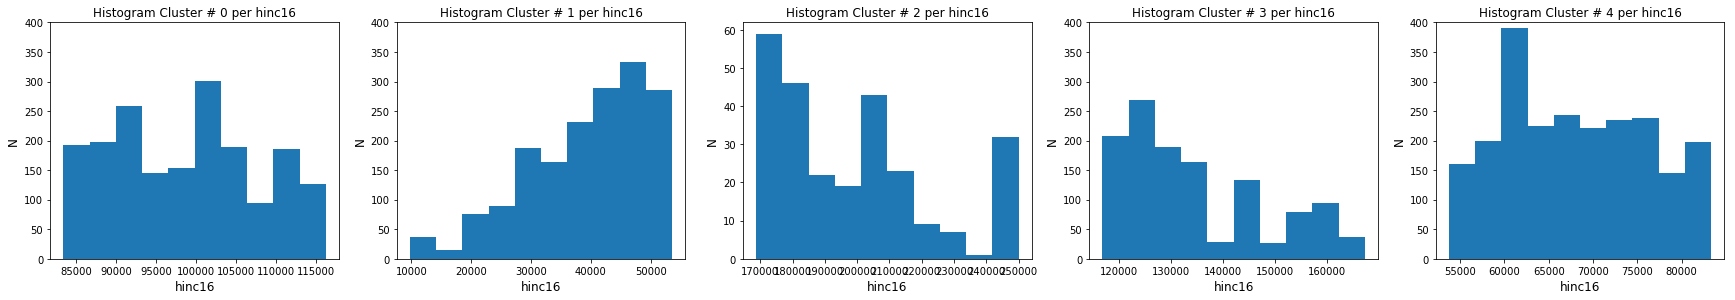

451
pop16
455


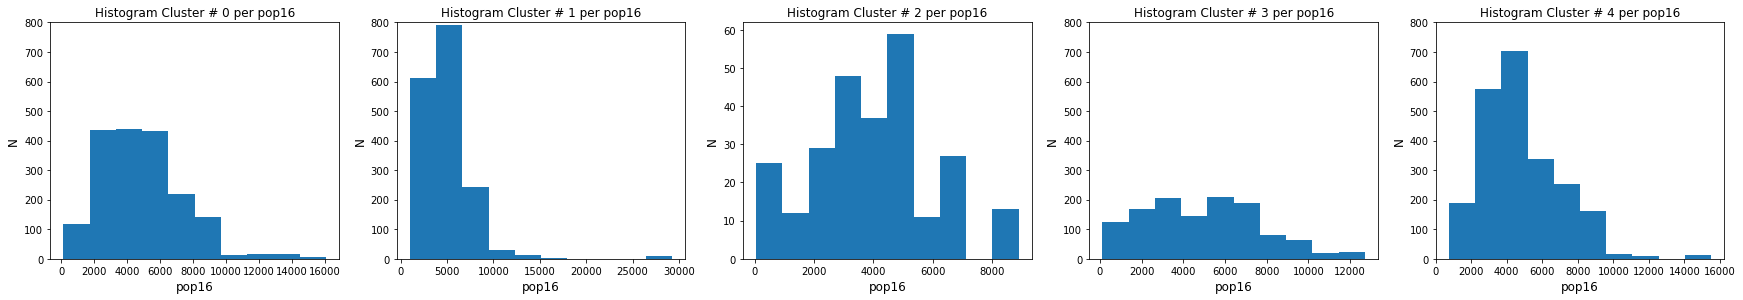

451
GEOID
455


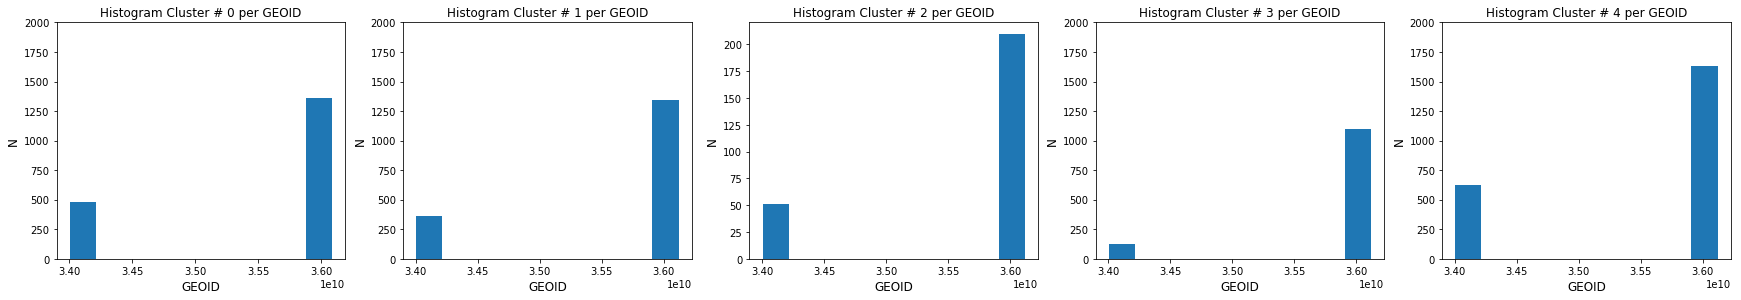

451
Rating
455


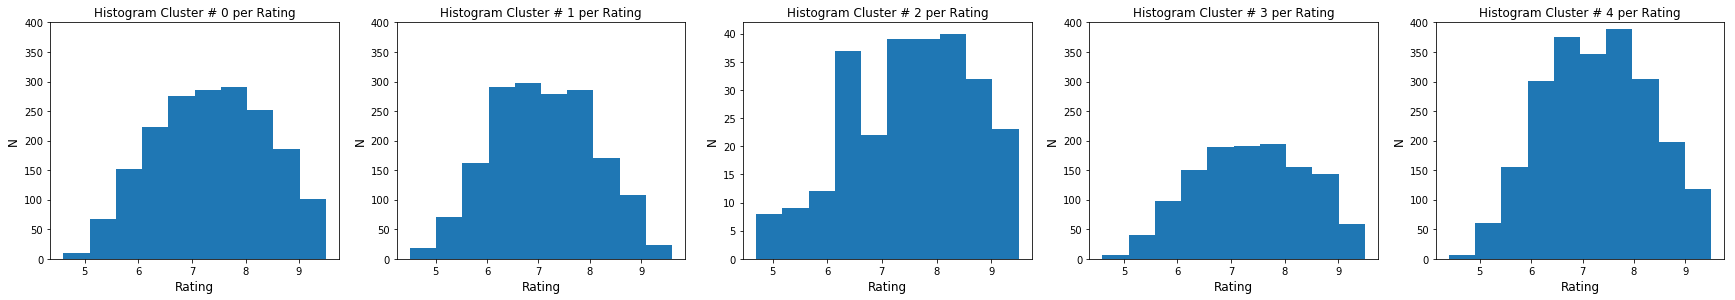

451
Checkins
455


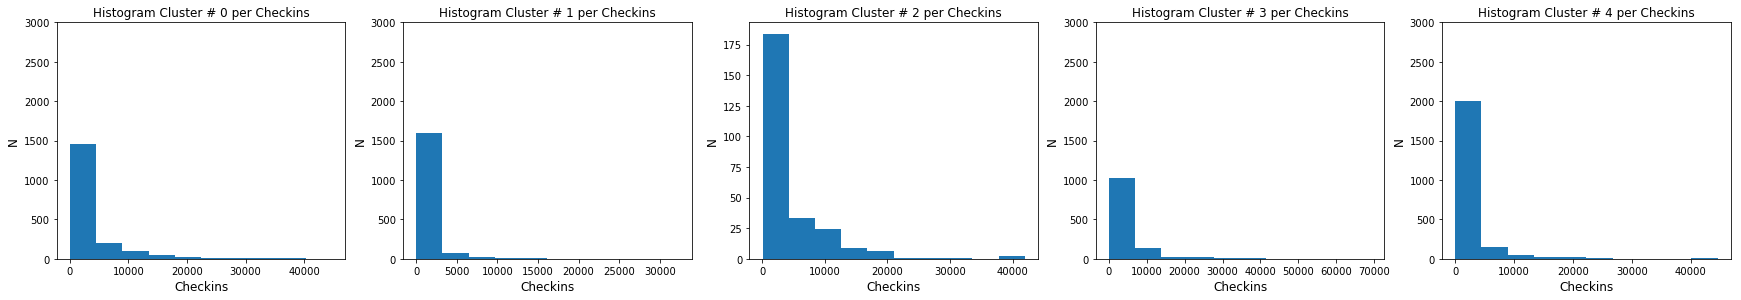

451
Users
455


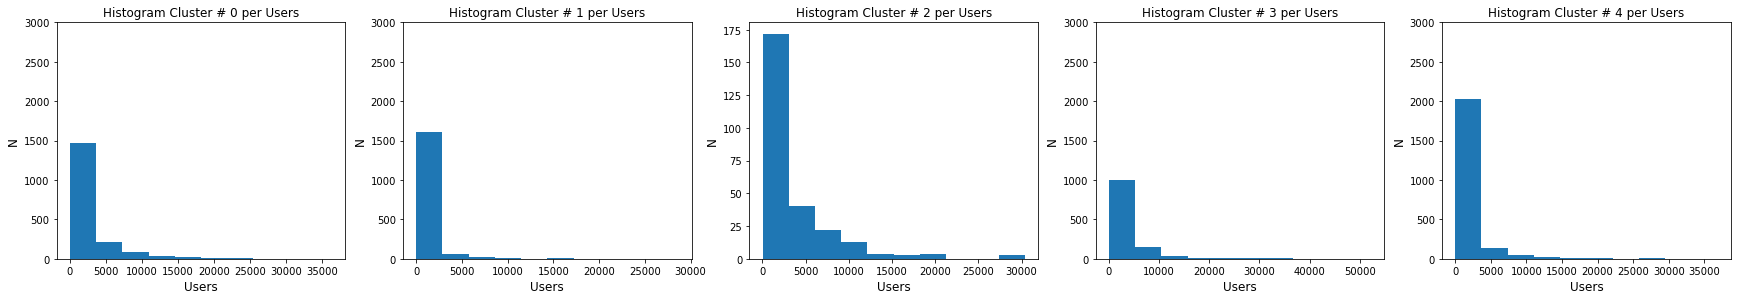

451
Visits
455


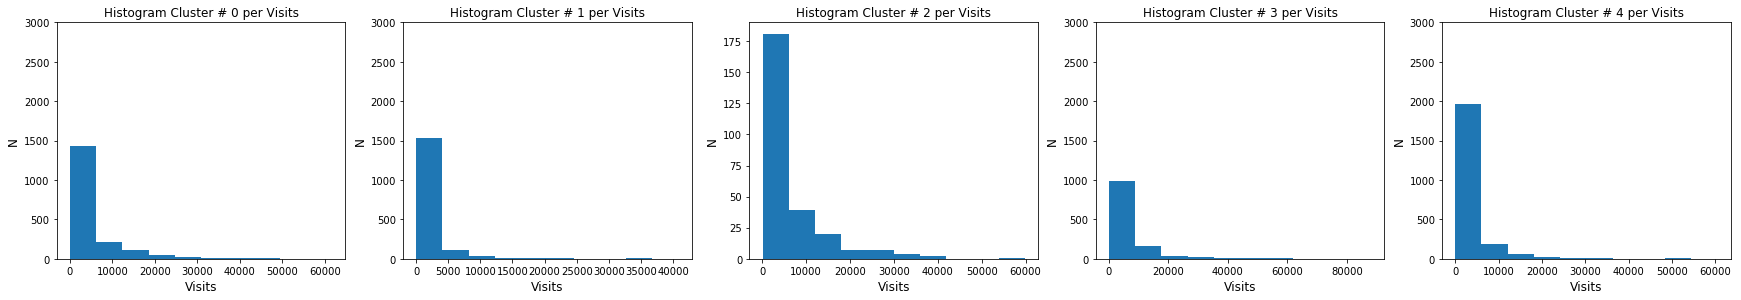

451
Pricing
455


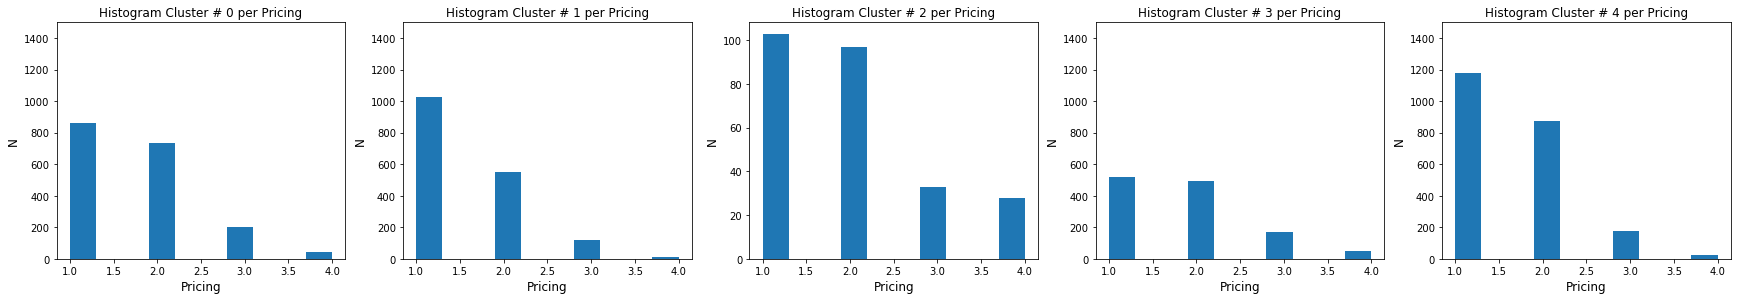

In [50]:
cols_histos = list(X_geoID.columns)[:-3]

cols_histos_values = [400,800,2000,400,3000,3000,3000,1500]
#     plt.ylim((0,400))
for i, column in enumerate(list(X_geoID.columns)[:-4]):
    start = 451
    seq = 0
    print(start + seq)
    print(column)
    plt.subplot(start + seq)
    plt.title('Histogram Cluster # 0 per '+column)
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.ylim((0,cols_histos_values[i]))

    plt.hist(list(X_geoID.loc[:,column][y == 0]))
    
    
    seq  += 1 
    plt.subplot(start + seq)
    plt.title('Histogram Cluster # 1 per '+column)
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.ylim((0,cols_histos_values[i]))

    plt.hist(list(X_geoID.loc[:,column][y == 1]))

#     plt.Figure(figsize=(5,5))
    
    seq  += 1
    plt.subplot(start + seq)
    plt.title('Histogram Cluster # 2 per '+column)
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.hist(list(X_geoID.loc[:,column][y == 2]))
#     plt.Figure(figsize=(5,5))
    
    seq  += 1 
    plt.subplot(start + seq)
    plt.title('Histogram Cluster # 3 per '+column)
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.ylim((0,cols_histos_values[i]))
    
    plt.hist(list(X_geoID.loc[:,column][y == 3]))
#     plt.Figure(figsize=(5,5))
    
    seq  += 1 
    print(start + seq)
    plt.subplot(start + seq)
    plt.title('Histogram Cluster # 4 per '+column)
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.hist(list(X_geoID.loc[:,column][y == 4]))
    plt.Figure(figsize=(5,1))
    plt.ylim((0,cols_histos_values[i]))
    plt.show()
    
    
#     plt.hist(list(maps.loc[:,column][y == 2]))
#     plt.hist(list(maps.loc[:,column][y == 3]))

#     plt.hist(list(maps.loc[:,column][y == 4]))

#     plt.hist(list(maps.loc[:,column][y == 5]))
#     clusters = ['med','vlow','vhigh','high','low']



451
455


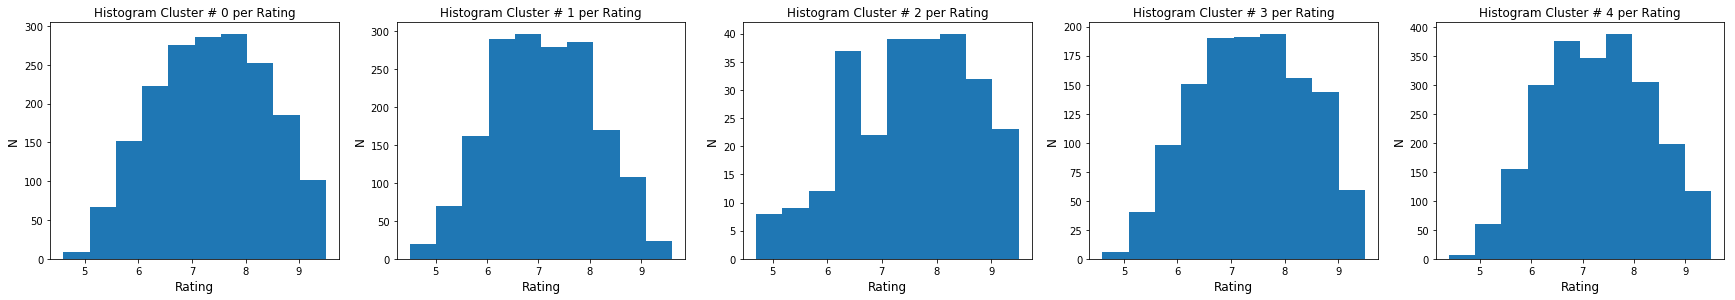

451
455


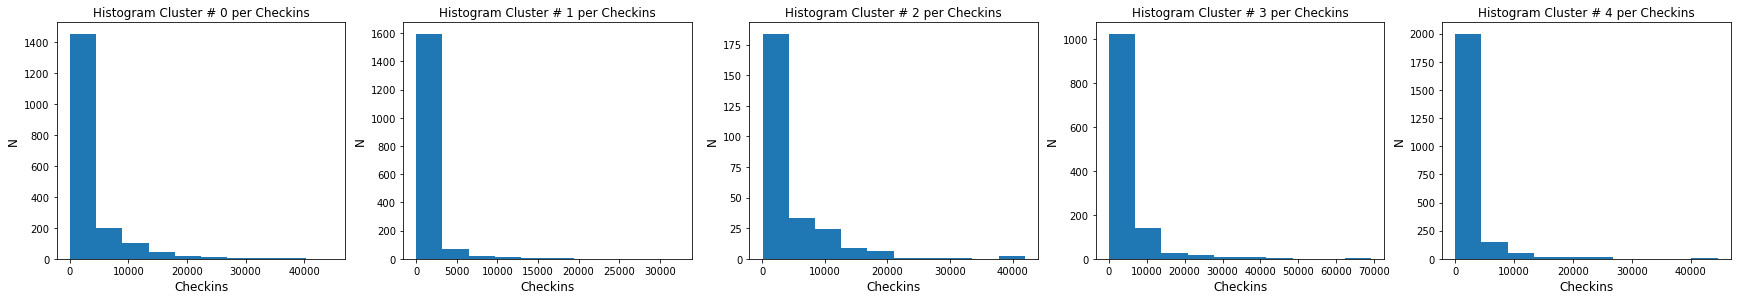

451
455


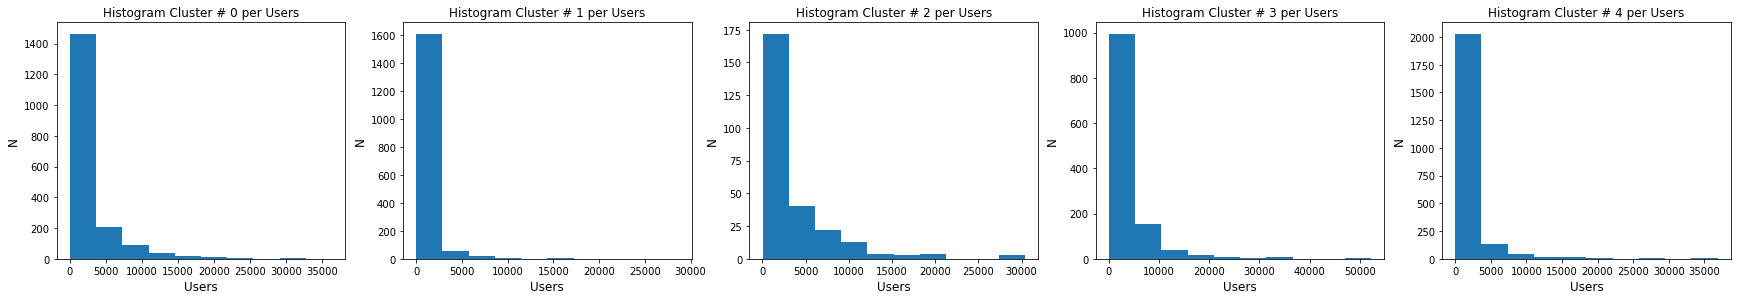

451
455


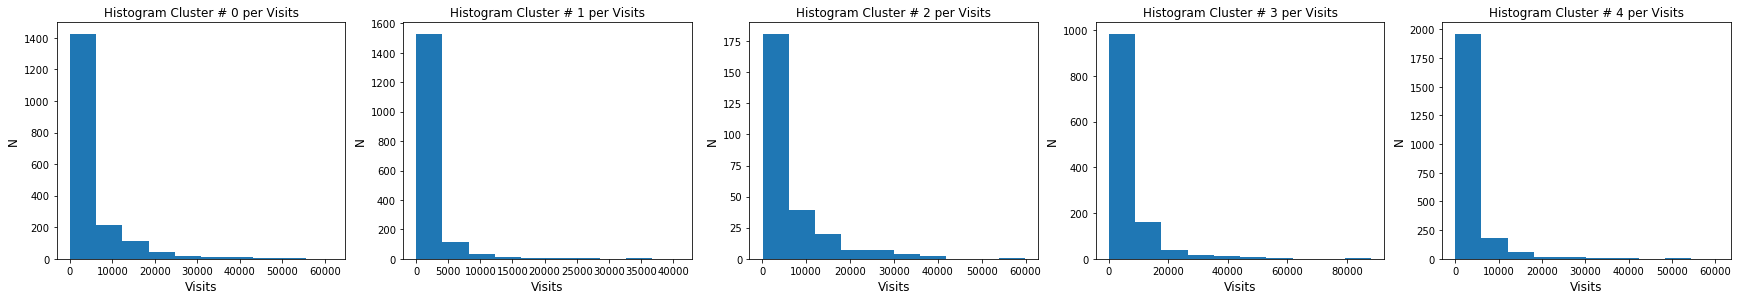

451
455


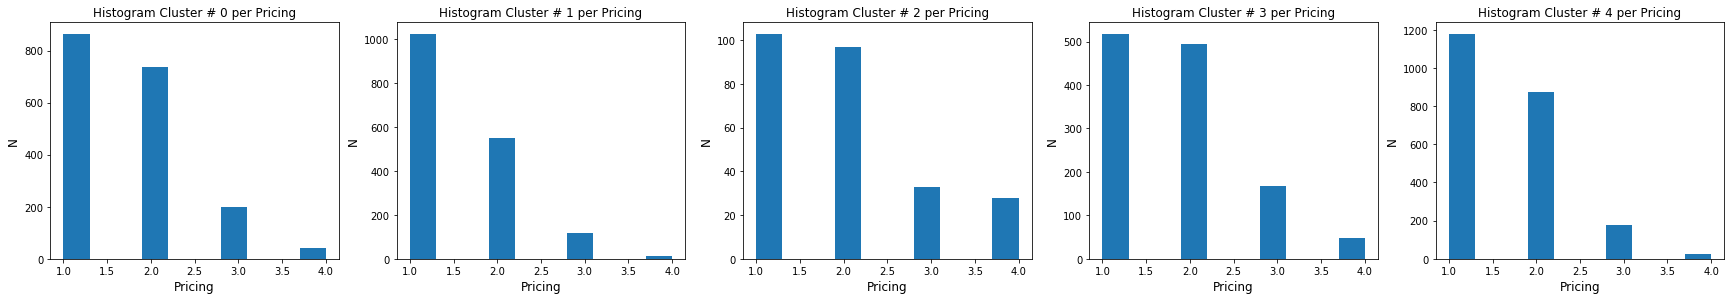

In [51]:
for i, column in enumerate(Foursquare.iloc[:,:5].columns):
    start = 451
    seq = 0
    print(start + seq)
    plt.subplot(start + seq)
    plt.title('Histogram Cluster # 0 per '+column)
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.hist(list(X_geoID.loc[:,column][y == 0]))
    
    seq  += 1 
    plt.subplot(start + seq)
    plt.title('Histogram Cluster # 1 per '+column)
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.hist(list(X_geoID.loc[:,column][y == 1]))
#     plt.Figure(figsize=(5,5))
    
    seq  += 1
    plt.subplot(start + seq)
    plt.title('Histogram Cluster # 2 per '+column)
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.hist(list(X_geoID.loc[:,column][y == 2]))
#     plt.Figure(figsize=(5,5))
    
    seq  += 1 
    plt.subplot(start + seq)
    plt.title('Histogram Cluster # 3 per '+column)
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.hist(list(X_geoID.loc[:,column][y == 3]))
#     plt.Figure(figsize=(5,5))
    
    seq  += 1 
    print(start + seq)
    plt.subplot(start + seq)
    plt.title('Histogram Cluster # 4 per '+column)
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.hist(list(X_geoID.loc[:,column][y == 4]))
    plt.Figure(figsize=(5,1))
    plt.show()
    
#     plt.hist(list(maps.loc[:,column][y == 2]))
#     plt.hist(list(maps.loc[:,column][y == 3]))

#     plt.hist(list(maps.loc[:,column][y == 4]))

#     plt.hist(list(maps.loc[:,column][y == 5]))
    

In [52]:
Foursquare.iloc[:,5:8].columns

Index(['Type', 'Category', 'Class'], dtype='object')

In [53]:
pdmaps_0.head(2)

,hinc16,pop16,GEOID,Rating,Checkins,Users,Visits,Pricing,Type,Category,Class,clusters
98,91827.0,1776.0,36061010000,7.4,6625.0,6193.0,7943.0,3.0,Hotel Bar,Social,Optional,0
99,91827.0,1776.0,36061010000,6.7,9859.0,7960.0,12600.0,1.0,Bar,Social,Optional,0


# Categorical Values -
Groupby Cat_variables

In [54]:
# len(maps.groupby(by='GEOID').mean().pop16)
X_geoID_dummies[X_geoID_dummies.GEOID == 34003003500]

,hinc16,pop16,GEOID,Rating,Checkins,Users,Visits,Pricing,Type_Afghan Restaurant,Type_African Restaurant,...,Type_Vietnamese Restaurant,Type_Whisky Bar,Type_Wine Bar,Type_Wings Joint,Category_Consumption,Category_Leisure,Category_Nutrition,Category_Social,Class_Necessary,Class_Optional
2977,52382.0,4100.0,34003003500,6.5,1278.0,1052.0,2234.0,2.0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [55]:
# cols_to_drop_m = [i for i in manhattan_df.columns.values if i != 'ZipCode' and i != 'LandUse']

columns_nogeoid = [i for i in X_geoID_dummies.columns.values if i!= 'GEOID']


In [56]:
# col = 'Type_Afghan Restaurant'
# X_geoID_dummies_grouped_CT_sum[col] = list(X_geoID_dummies.groupby(by='GEOID', axis=0).sum()[col])
# X_geoID_dummies_grouped_CT_sum


In [68]:
# for column in columns_nogeoid[7:]:
X_geoID_dummies_grouped_CT_sum =  X_geoID_dummies.drop(columns=['hinc16','pop16']).groupby(by='GEOID', axis=0).sum()

# X_geoID_dummies.groupby(by='GEOID', axis=0).sum()[column]
X_geoID_dummies_grouped_CT_sum.head(2)

,Rating,Checkins,Users,Visits,Pricing,Type_Afghan Restaurant,Type_African Restaurant,Type_American Restaurant,Type_Arepa Restaurant,Type_Argentinian Restaurant,...,Type_Vietnamese Restaurant,Type_Whisky Bar,Type_Wine Bar,Type_Wings Joint,Category_Consumption,Category_Leisure,Category_Nutrition,Category_Social,Class_Necessary,Class_Optional
GEOID,,,,,,,,,,,,,,,,,,,,,
34003003500,6.5,1278.0,1052.0,2234.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
34003004002,8.0,2190.0,893.0,3224.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [72]:
X_geoID_dummies_grouped_CT_sum.loc[36061007100]

Rating                                     150.5
Checkins                                136090.0
Users                                   115642.0
Visits                                  191575.0
Pricing                                     37.0
Type_Afghan Restaurant                       0.0
Type_African Restaurant                      0.0
Type_American Restaurant                     0.0
Type_Arepa Restaurant                        0.0
Type_Argentinian Restaurant                  0.0
Type_Asian Restaurant                        0.0
Type_Australian Restaurant                   0.0
Type_Austrian Restaurant                     0.0
Type_BBQ Joint                               0.0
Type_Bagel Shop                              0.0
Type_Bakery                                  2.0
Type_Bar                                     1.0
Type_Bavarian Restaurant                     0.0
Type_Beer Bar                                0.0
Type_Beer Garden                             0.0
Type_Belgian Restaur

In [70]:
X_geoID_dummies[X_geoID_dummies.GEOID==36061007100]

,hinc16,pop16,GEOID,Rating,Checkins,Users,Visits,Pricing,Type_Afghan Restaurant,Type_African Restaurant,...,Type_Vietnamese Restaurant,Type_Whisky Bar,Type_Wine Bar,Type_Wings Joint,Category_Consumption,Category_Leisure,Category_Nutrition,Category_Social,Class_Necessary,Class_Optional
0,127904.0,6038.0,36061007100,7.5,7129.0,4556.0,7886.0,2.0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,127904.0,6038.0,36061007100,6.1,23722.0,18806.0,28049.0,2.0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,127904.0,6038.0,36061007100,7.1,2095.0,2596.0,3949.0,1.0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,127904.0,6038.0,36061007100,7.8,10191.0,7352.0,14328.0,1.0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,127904.0,6038.0,36061007100,8.8,17312.0,9611.0,23679.0,1.0,0,0,...,0,0,0,0,0,0,0,1,0,1
5,127904.0,6038.0,36061007100,7.6,1364.0,783.0,1424.0,1.0,0,0,...,0,0,0,0,0,0,1,0,1,0
6,127904.0,6038.0,36061007100,9.0,7004.0,5219.0,8322.0,3.0,0,0,...,0,0,1,0,0,0,0,1,0,1
7,127904.0,6038.0,36061007100,9.4,17804.0,14305.0,25861.0,3.0,0,0,...,0,0,0,0,0,0,0,1,0,1
8,127904.0,6038.0,36061007100,7.9,3429.0,3644.0,5060.0,3.0,0,0,...,0,0,0,0,0,0,0,1,0,1
9,127904.0,6038.0,36061007100,7.3,449.0,476.0,722.0,1.0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [73]:
# range_n_clusters = range(2,10)
# X_clusterize_hinc16 = np.asarray(X_geoID_dummies_grouped_CT_mean.hinc16).reshape(len(X_geoID_dummies_grouped_CT_mean.hinc16),1)
# print(X_clusterize_hinc16.shape)
# for n_clusters in range_n_clusters:
#     km = KMeans(n_clusters = n_clusters)
#     res=km.fit(X_clusterize_hinc16)
#     silhouette_avg = silhouette_score(X_clusterize_hinc16, res.labels_)
#     print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))



In [74]:
# SSE = []
# for i in range(2,10):
#     km = KMeans(n_clusters = i)
#     res=km.fit(X_clusterize_hinc16)
#     SSE.append(res.inertia_)
# print(SSE)

# plt.gca()
# plt.plot(range(2,10),SSE)
# plt.xlabel("Clusters")
# plt.ylabel("Sum of squared errors")
# plt.title("SSE vs. number of clusters")
# plt.xlim(1.5,9.5)
# plt.show()


In [75]:
# CONCLUSION
n_clusters = 5

In [77]:
# len(X_geoID_dummies_grouped_CT) , len(y_grouped_CT)

In [78]:
X_geoID_dummies_grouped_CT_mean = X_geoID_dummies.groupby(by='GEOID', axis=0).mean()


In [79]:
km = KMeans(random_state=234,n_clusters=n_clusters)
res=km.fit(np.asarray(X_geoID_dummies_grouped_CT_mean.hinc16).reshape(len(X_geoID_dummies_grouped_CT_mean.hinc16),1))
y_grouped_CT_mean = res.labels_
y_grouped_CT_mean.shape

(1725,)

In [80]:
X_geoID_dummies_grouped_CT_mean['clusters'] = y_grouped_CT_mean
X_geoID_dummies_grouped_CT_sum['clusters'] = y_grouped_CT_mean

In [81]:
clusters_groupedbyCT = ['low','high','vlow','vhigh','med']

In [82]:
pdmaps_grouped_CT_sum = {}
pdmaps_grouped_CT_sum['All'] = X_geoID_dummies_grouped_CT_sum
pdmaps_grouped_CT_mean = {}
pdmaps_grouped_CT_mean['All'] = X_geoID_dummies_grouped_CT_mean
mean_income = []
for i, cluster in enumerate(clusters_groupedbyCT):
    pdmaps_grouped_CT_sum[cluster] = pd.DataFrame(X_geoID_dummies_grouped_CT_sum[y_grouped_CT_mean == i])    
    pdmaps_grouped_CT_mean[cluster] = pd.DataFrame(X_geoID_dummies_grouped_CT_mean[y_grouped_CT_mean == i])    
    print(cluster)
    print('size',len(pdmaps_grouped_CT_mean[cluster]))
    print('income:',pdmaps_grouped_CT_mean[cluster].describe()['hinc16'].loc['mean'])
    mean_income.append(pdmaps_grouped_CT_mean[cluster].describe()['hinc16'].loc['mean'])

low
size 599
income: 60052.7195326
high
size 174
income: 124062.885057
vlow
size 508
income: 35520.3405512
vhigh
size 40
income: 185989.475
med
size 404
income: 87065.7970297


In [83]:
pd_combined_describe = pdmaps_grouped_CT_sum['All'].iloc[:,-7:].describe().copy()
cols_cat_class = pd_combined_describe.columns

In [84]:
# pd_combined_describe = pdmaps_grouped_CT_sum['All'].iloc[:,-7:].describe().copy()
# for i, cluster in enumerate(clusters_groupedbyCT):
#     for column in list(pd_combined_describe.columns):
#         pd_combined_describe[column+'_'+cluster] = pdmaps_grouped_CT_mean[cluster].describe()[column]
# pd_combined_describe

In [85]:
len(cols_cat_class), clusters_groupedbyCT

(7, ['low', 'high', 'vlow', 'vhigh', 'med'])

In [86]:
column = cols_cat_class[0]
for i, cluster in enumerate(clusters_groupedbyCT):        
    pd_combined_describe[column+'_'+cluster] = pdmaps_grouped_CT_mean[cluster].describe()[column]
pd_combined_describe

,Category_Consumption,Category_Leisure,Category_Nutrition,Category_Social,Class_Necessary,Class_Optional,clusters,Category_Consumption_low,Category_Consumption_high,Category_Consumption_vlow,Category_Consumption_vhigh,Category_Consumption_med
count,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,599.000000,174.000000,508.000000,40.000000,404.000000
mean,0.398261,0.005217,1.069565,2.755362,1.069565,3.158841,1.696232,0.125630,0.103056,0.132955,0.069975,0.103579
std,0.719868,0.072064,1.555182,4.268454,1.555182,4.590194,1.535887,0.265892,0.193628,0.285665,0.109807,0.209569
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,3.000000,1.000000,3.000000,3.000000,0.101724,0.141234,0.000000,0.119048,0.132018
max,6.000000,1.000000,15.000000,39.000000,15.000000,41.000000,4.000000,1.000000,1.000000,1.000000,0.500000,1.000000


In [87]:
column = cols_cat_class[1]
for i, cluster in enumerate(clusters_groupedbyCT):        
    pd_combined_describe[column+'_'+cluster] = pdmaps_grouped_CT_mean[cluster].describe()[column]
pd_combined_describe

,Category_Consumption,Category_Leisure,Category_Nutrition,Category_Social,Class_Necessary,Class_Optional,clusters,Category_Consumption_low,Category_Consumption_high,Category_Consumption_vlow,Category_Consumption_vhigh,Category_Consumption_med,Category_Leisure_low,Category_Leisure_high,Category_Leisure_vlow,Category_Leisure_vhigh,Category_Leisure_med
count,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,599.000000,174.000000,508.000000,40.000000,404.000000,599.000000,174.000000,508.000000,40.0,404.000000
mean,0.398261,0.005217,1.069565,2.755362,1.069565,3.158841,1.696232,0.125630,0.103056,0.132955,0.069975,0.103579,0.003965,0.003592,0.001969,0.0,0.000603
std,0.719868,0.072064,1.555182,4.268454,1.555182,4.590194,1.535887,0.265892,0.193628,0.285665,0.109807,0.209569,0.058816,0.039018,0.044368,0.0,0.009124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,1.000000,0.000000,1.000000,3.000000,1.000000,3.000000,3.000000,0.101724,0.141234,0.000000,0.119048,0.132018,0.000000,0.000000,0.000000,0.0,0.000000
max,6.000000,1.000000,15.000000,39.000000,15.000000,41.000000,4.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,0.500000,1.000000,0.0,0.166667


In [88]:
column = cols_cat_class[2]
for i, cluster in enumerate(clusters_groupedbyCT):        
    pd_combined_describe[column+'_'+cluster] = pdmaps_grouped_CT_mean[cluster].describe()[column]
pd_combined_describe

,Category_Consumption,Category_Leisure,Category_Nutrition,Category_Social,Class_Necessary,Class_Optional,clusters,Category_Consumption_low,Category_Consumption_high,Category_Consumption_vlow,...,Category_Leisure_low,Category_Leisure_high,Category_Leisure_vlow,Category_Leisure_vhigh,Category_Leisure_med,Category_Nutrition_low,Category_Nutrition_high,Category_Nutrition_vlow,Category_Nutrition_vhigh,Category_Nutrition_med
count,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,599.000000,174.000000,508.000000,...,599.000000,174.000000,508.000000,40.0,404.000000,599.000000,174.000000,508.000000,40.000000,404.000000
mean,0.398261,0.005217,1.069565,2.755362,1.069565,3.158841,1.696232,0.125630,0.103056,0.132955,...,0.003965,0.003592,0.001969,0.0,0.000603,0.282120,0.253578,0.306789,0.239444,0.262517
std,0.719868,0.072064,1.555182,4.268454,1.555182,4.590194,1.535887,0.265892,0.193628,0.285665,...,0.058816,0.039018,0.044368,0.0,0.009124,0.340118,0.243249,0.365755,0.236154,0.311548
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.181818,0.215251,0.200000,0.194357,0.177116
75%,1.000000,0.000000,1.000000,3.000000,1.000000,3.000000,3.000000,0.101724,0.141234,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.500000,0.333333,0.500000,0.343750,0.381250
max,6.000000,1.000000,15.000000,39.000000,15.000000,41.000000,4.000000,1.000000,1.000000,1.000000,...,1.000000,0.500000,1.000000,0.0,0.166667,1.000000,1.000000,1.000000,1.000000,1.000000


In [89]:
column = cols_cat_class[3]
for i, cluster in enumerate(clusters_groupedbyCT):        
    pd_combined_describe[column+'_'+cluster] = pdmaps_grouped_CT_mean[cluster].describe()[column]
pd_combined_describe

,Category_Consumption,Category_Leisure,Category_Nutrition,Category_Social,Class_Necessary,Class_Optional,clusters,Category_Consumption_low,Category_Consumption_high,Category_Consumption_vlow,...,Category_Nutrition_low,Category_Nutrition_high,Category_Nutrition_vlow,Category_Nutrition_vhigh,Category_Nutrition_med,Category_Social_low,Category_Social_high,Category_Social_vlow,Category_Social_vhigh,Category_Social_med
count,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,599.000000,174.000000,508.000000,...,599.000000,174.000000,508.000000,40.000000,404.000000,599.000000,174.000000,508.000000,40.000000,404.000000
mean,0.398261,0.005217,1.069565,2.755362,1.069565,3.158841,1.696232,0.125630,0.103056,0.132955,...,0.282120,0.253578,0.306789,0.239444,0.262517,0.588286,0.639774,0.558288,0.690582,0.633301
std,0.719868,0.072064,1.555182,4.268454,1.555182,4.590194,1.535887,0.265892,0.193628,0.285665,...,0.340118,0.243249,0.365755,0.236154,0.311548,0.382115,0.285754,0.403105,0.279234,0.339237
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.500000,0.000000,0.569196,0.500000
50%,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,...,0.181818,0.215251,0.200000,0.194357,0.177116,0.666667,0.666667,0.600000,0.755952,0.666667
75%,1.000000,0.000000,1.000000,3.000000,1.000000,3.000000,3.000000,0.101724,0.141234,0.000000,...,0.500000,0.333333,0.500000,0.343750,0.381250,1.000000,0.844615,1.000000,0.865079,1.000000
max,6.000000,1.000000,15.000000,39.000000,15.000000,41.000000,4.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [90]:
column = cols_cat_class[4]
for i, cluster in enumerate(clusters_groupedbyCT):        
    pd_combined_describe[column+'_'+cluster] = pdmaps_grouped_CT_mean[cluster].describe()[column]
pd_combined_describe

,Category_Consumption,Category_Leisure,Category_Nutrition,Category_Social,Class_Necessary,Class_Optional,clusters,Category_Consumption_low,Category_Consumption_high,Category_Consumption_vlow,...,Category_Social_low,Category_Social_high,Category_Social_vlow,Category_Social_vhigh,Category_Social_med,Class_Necessary_low,Class_Necessary_high,Class_Necessary_vlow,Class_Necessary_vhigh,Class_Necessary_med
count,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,599.000000,174.000000,508.000000,...,599.000000,174.000000,508.000000,40.000000,404.000000,599.000000,174.000000,508.000000,40.000000,404.000000
mean,0.398261,0.005217,1.069565,2.755362,1.069565,3.158841,1.696232,0.125630,0.103056,0.132955,...,0.588286,0.639774,0.558288,0.690582,0.633301,0.282120,0.253578,0.306789,0.239444,0.262517
std,0.719868,0.072064,1.555182,4.268454,1.555182,4.590194,1.535887,0.265892,0.193628,0.285665,...,0.382115,0.285754,0.403105,0.279234,0.339237,0.340118,0.243249,0.365755,0.236154,0.311548
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.333333,0.500000,0.000000,0.569196,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,...,0.666667,0.666667,0.600000,0.755952,0.666667,0.181818,0.215251,0.200000,0.194357,0.177116
75%,1.000000,0.000000,1.000000,3.000000,1.000000,3.000000,3.000000,0.101724,0.141234,0.000000,...,1.000000,0.844615,1.000000,0.865079,1.000000,0.500000,0.333333,0.500000,0.343750,0.381250
max,6.000000,1.000000,15.000000,39.000000,15.000000,41.000000,4.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [91]:
column = cols_cat_class[5]
for i, cluster in enumerate(clusters_groupedbyCT):        
    pd_combined_describe[column+'_'+cluster] = pdmaps_grouped_CT_mean[cluster].describe()[column]
pd_combined_describe

,Category_Consumption,Category_Leisure,Category_Nutrition,Category_Social,Class_Necessary,Class_Optional,clusters,Category_Consumption_low,Category_Consumption_high,Category_Consumption_vlow,...,Class_Necessary_low,Class_Necessary_high,Class_Necessary_vlow,Class_Necessary_vhigh,Class_Necessary_med,Class_Optional_low,Class_Optional_high,Class_Optional_vlow,Class_Optional_vhigh,Class_Optional_med
count,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,599.000000,174.000000,508.000000,...,599.000000,174.000000,508.000000,40.000000,404.000000,599.000000,174.000000,508.000000,40.000000,404.000000
mean,0.398261,0.005217,1.069565,2.755362,1.069565,3.158841,1.696232,0.125630,0.103056,0.132955,...,0.282120,0.253578,0.306789,0.239444,0.262517,0.717880,0.746422,0.693211,0.760556,0.737483
std,0.719868,0.072064,1.555182,4.268454,1.555182,4.590194,1.535887,0.265892,0.193628,0.285665,...,0.340118,0.243249,0.365755,0.236154,0.311548,0.340118,0.243249,0.365755,0.236154,0.311548
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.666667,0.500000,0.656250,0.618750
50%,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,...,0.181818,0.215251,0.200000,0.194357,0.177116,0.818182,0.784749,0.800000,0.805643,0.822884
75%,1.000000,0.000000,1.000000,3.000000,1.000000,3.000000,3.000000,0.101724,0.141234,0.000000,...,0.500000,0.333333,0.500000,0.343750,0.381250,1.000000,1.000000,1.000000,1.000000,1.000000
max,6.000000,1.000000,15.000000,39.000000,15.000000,41.000000,4.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [98]:
# pd_combined_describe = pdmaps_grouped_CT_sum['All'].iloc[:,:7].describe().copy()
# for i, cluster in enumerate(clusters_groupedbyCT):
#     for column in list(pd_combined_describe.columns):
#         pd_combined_describe[column+'_'+cluster] = pdmaps_grouped_CT_mean[cluster].describe()[column]
# pd_combined_describe


In [93]:
maps_grouped_CT_sum_mean_bypop = {}
for fq in list(Foursquare.columns[-3:]):
    print(fq)
    maps_grouped_CT_sum_mean_bypop[fq] = {}
    for i, cluster in enumerate(clusters_groupedbyCT+['All']):
        maps_grouped_CT_sum_mean_bypop[fq][cluster] = {}
        for fq_specific in list(X_geoID_dummies_grouped_CT_sum.columns):
             if (fq in fq_specific): 
#                 print(fq_specific)
#                 print(cluster)
                maps_grouped_CT_sum_mean_bypop[fq][cluster][fq_specific+'_total_'+str(pdmaps_grouped_CT_sum['All'][fq_specific].sum())] = \
            pdmaps_grouped_CT_sum[cluster][fq_specific].mean()/pdmaps_grouped_CT_mean[cluster]['pop16'].mean()

Type
Category
Class


In [99]:
maps_grouped_CT_sum_mean_bypop['Category']

{'All': {'Category_Consumption_total_687': 8.8568455293944144e-05,
  'Category_Leisure_total_9': 1.1602854405320193e-06,
  'Category_Nutrition_total_1845': 0.00023785851530906397,
  'Category_Social_total_4753': 0.0006127596332054097},
 'high': {'Category_Consumption_total_687': 0.00014155898072775591,
  'Category_Leisure_total_9': 2.3791425332395954e-06,
  'Category_Nutrition_total_1845': 0.00044133093991594491,
  'Category_Social_total_4753': 0.0012383436885512094},
 'low': {'Category_Consumption_total_687': 8.3198136361745502e-05,
  'Category_Leisure_total_9': 1.6154977934319514e-06,
  'Category_Nutrition_total_1845': 0.0002128418342846596,
  'Category_Social_total_4753': 0.00052059416393344623},
 'med': {'Category_Consumption_total_687': 0.00010315253804363844,
  'Category_Leisure_total_9': 1.0915612491390309e-06,
  'Category_Nutrition_total_1845': 0.0002510590873019771,
  'Category_Social_total_4753': 0.0007417158687899716},
 'vhigh': {'Category_Consumption_total_687': 0.000146803

In [100]:
maps_grouped_CT_sum_mean = {}
for fq in list(Foursquare.columns[-3:]):
    print(fq)
    maps_grouped_CT_sum_mean[fq] = {}
    for i, cluster in enumerate(clusters_groupedbyCT+['All']):
        maps_grouped_CT_sum_mean[fq][cluster] = {}
        for fq_specific in list(X_geoID_dummies_grouped_CT_sum.columns):
             if (fq in fq_specific): 
#                 print('cluster',cluster, 'fq_specific',fq_specific)
#                 print(cluster)
                maps_grouped_CT_sum_mean[fq][cluster]
                maps_grouped_CT_sum_mean[fq][cluster][fq_specific+'_total_'+str(pdmaps_grouped_CT_sum['All'][fq_specific].sum())]  = \
                        pdmaps_grouped_CT_sum[cluster][fq_specific].mean()

Type
Category
Class


In [101]:
maps_grouped_CT_sum_mean['Category']

{'All': {'Category_Consumption_total_687': 0.39826086956521739,
  'Category_Leisure_total_9': 0.0052173913043478265,
  'Category_Nutrition_total_1845': 1.0695652173913044,
  'Category_Social_total_4753': 2.7553623188405796},
 'high': {'Category_Consumption_total_687': 0.68390804597701149,
  'Category_Leisure_total_9': 0.011494252873563218,
  'Category_Nutrition_total_1845': 2.132183908045977,
  'Category_Social_total_4753': 5.9827586206896548},
 'low': {'Category_Consumption_total_687': 0.34390651085141904,
  'Category_Leisure_total_9': 0.0066777963272120202,
  'Category_Nutrition_total_1845': 0.87979966611018368,
  'Category_Social_total_4753': 2.1519198664440733},
 'med': {'Category_Consumption_total_687': 0.46782178217821785,
  'Category_Leisure_total_9': 0.0049504950495049506,
  'Category_Nutrition_total_1845': 1.1386138613861385,
  'Category_Social_total_4753': 3.363861386138614},
 'vhigh': {'Category_Consumption_total_687': 0.59999999999999998,
  'Category_Leisure_total_9': 0.0,


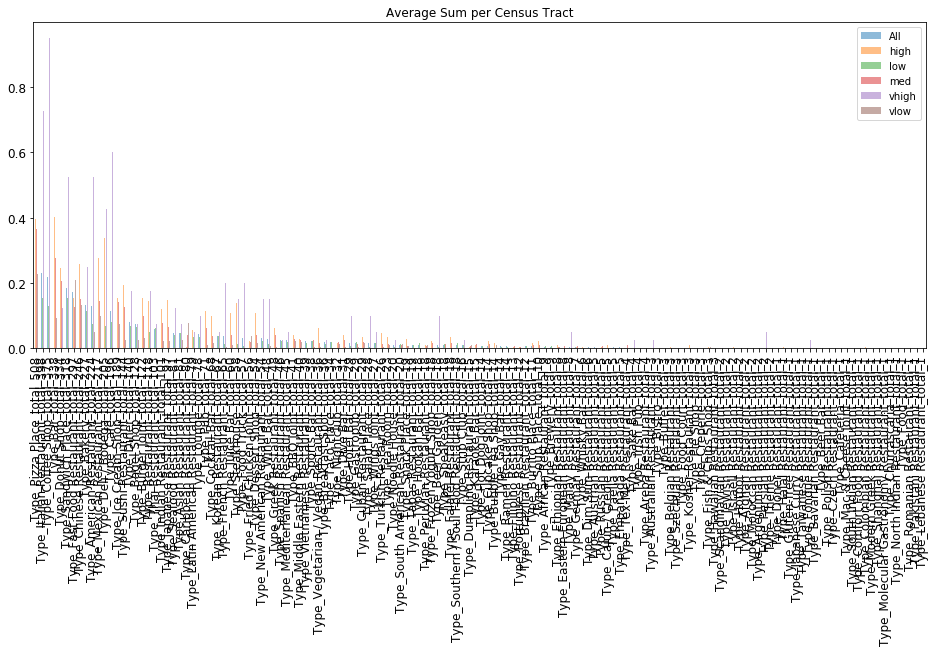

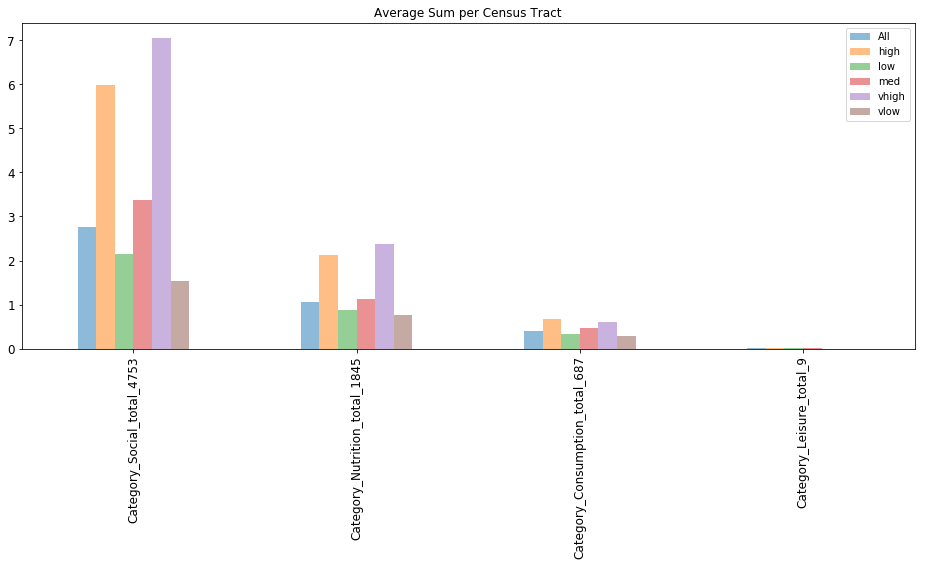

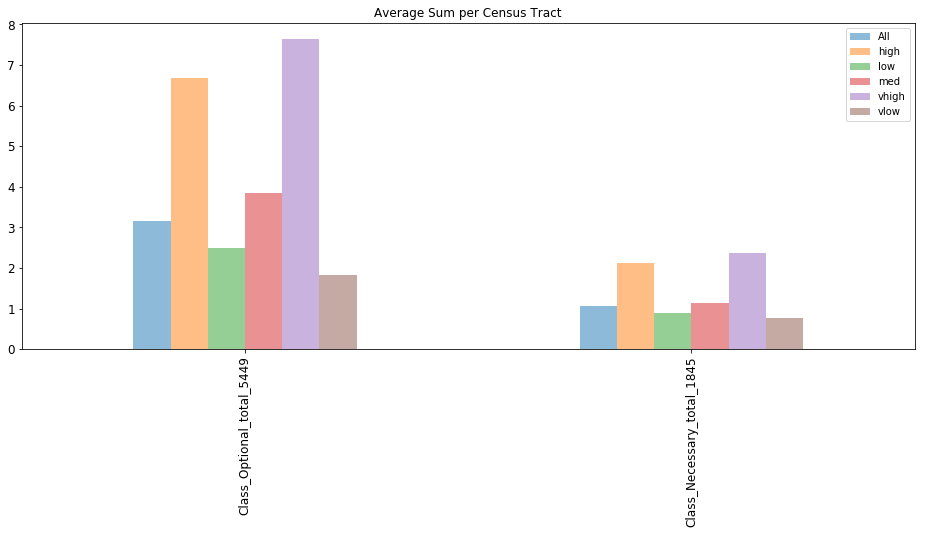

In [102]:
pd_plot_CT_sum_mean =  {}
for fq in list(Foursquare.columns[-3:]):
    pd_plot_CT_sum_mean[fq] = pd.DataFrame(maps_grouped_CT_sum_mean[fq])
    pd_plot_CT_sum_mean[fq].sort_values(by=['All'],axis=0,ascending=False, inplace=True)
    plt.figure()
    pd_plot_CT_sum_mean[fq].plot.bar(alpha=0.5,figsize=(16,6), title='Average Sum per Census Tract', fontsize=12)
    plt.legend()

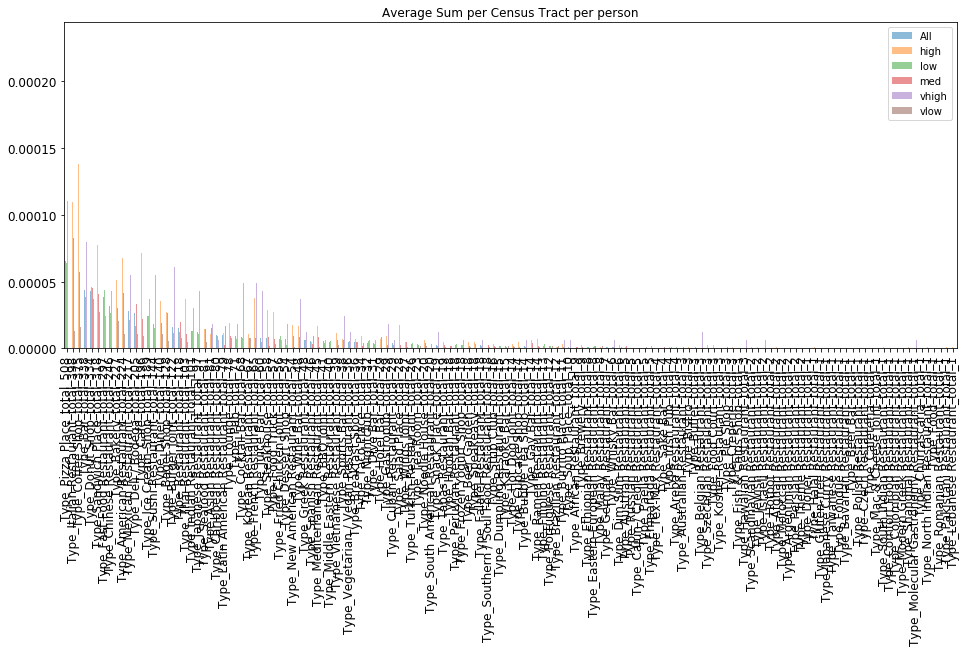

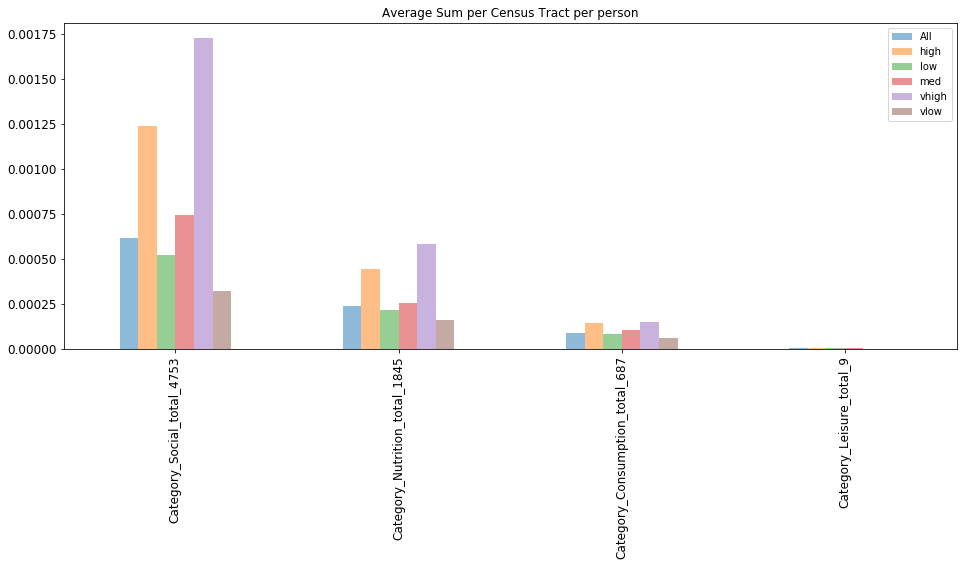

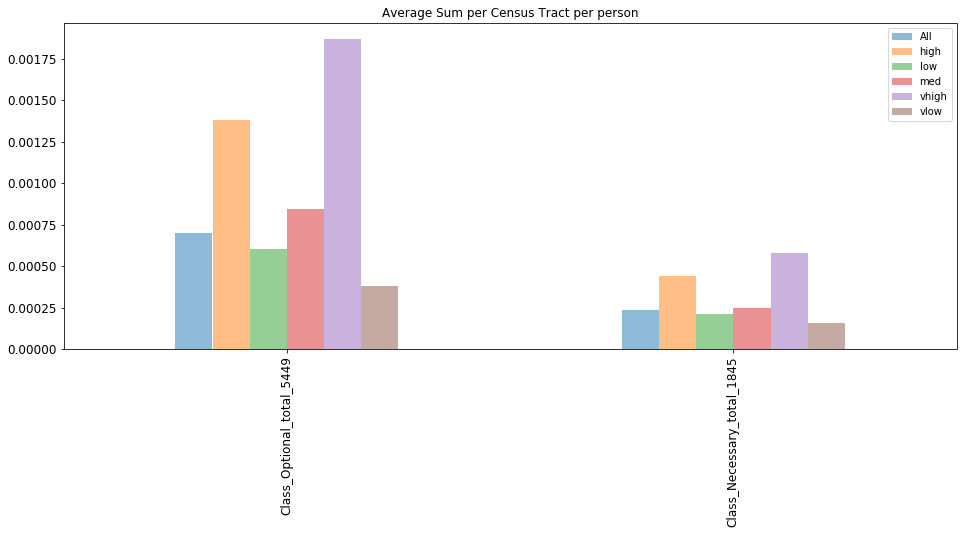

In [103]:
pd_plot_CT_sum_mean_pop =  {}
for fq in list(Foursquare.columns[-3:]):
    
    pd_plot_CT_sum_mean_pop[fq] = pd.DataFrame(maps_grouped_CT_sum_mean_bypop[fq])
    pd_plot_CT_sum_mean_pop[fq].sort_values(by=['All'],axis=0,ascending=False, inplace=True)
    plt.figure()
    pd_plot_CT_sum_mean_pop[fq].plot.bar(alpha=0.5,figsize=(16,6), title='Average Sum per Census Tract per person', fontsize=12)
    plt.legend()

In [104]:
pd_plot_CT_sum_mean[fq]

,All,high,low,med,vhigh,vlow
Class_Optional_total_5449,3.158841,6.678161,2.502504,3.836634,7.650,1.834646
Class_Necessary_total_1845,1.069565,2.132184,0.879800,1.138614,2.375,0.771654


In [106]:
# len(pdaggregate_meanbypop['low']), 
pdmaps_grouped_CT_mean['low'].shape

(599, 156)

[0, 35]
0
0 35
[0, 35, 70]
1
35 70
[0, 35, 70, 105]
2
70 105


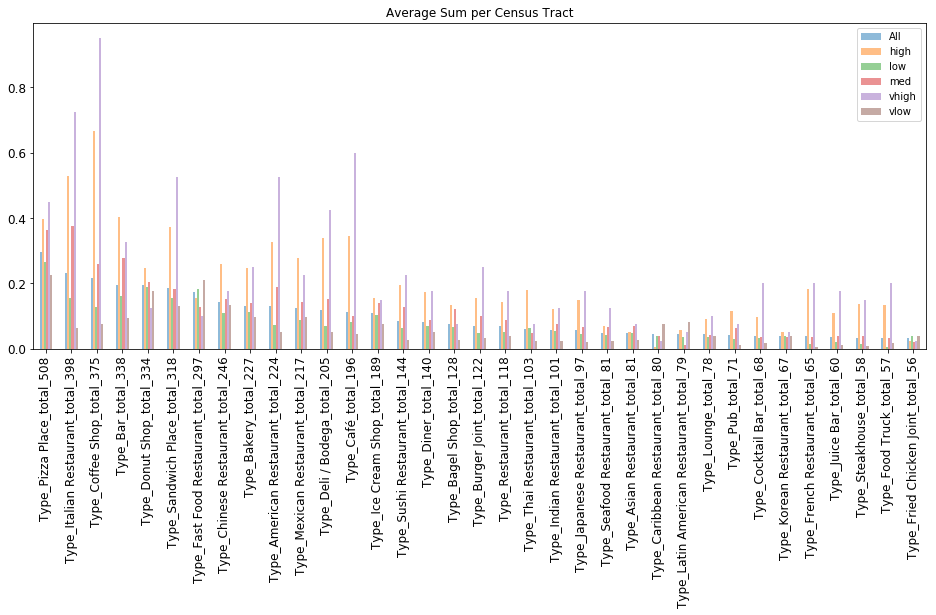

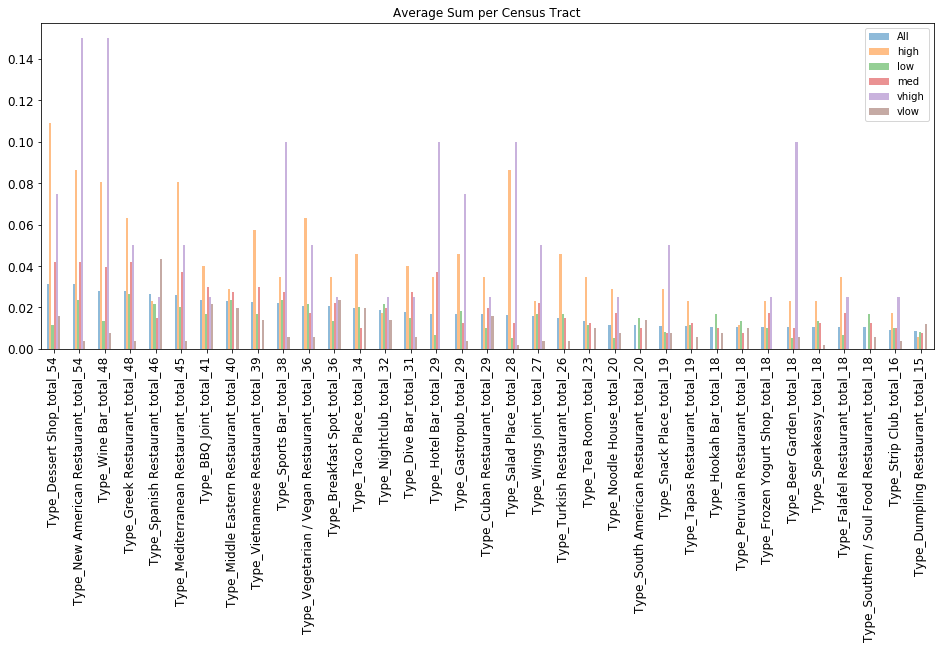

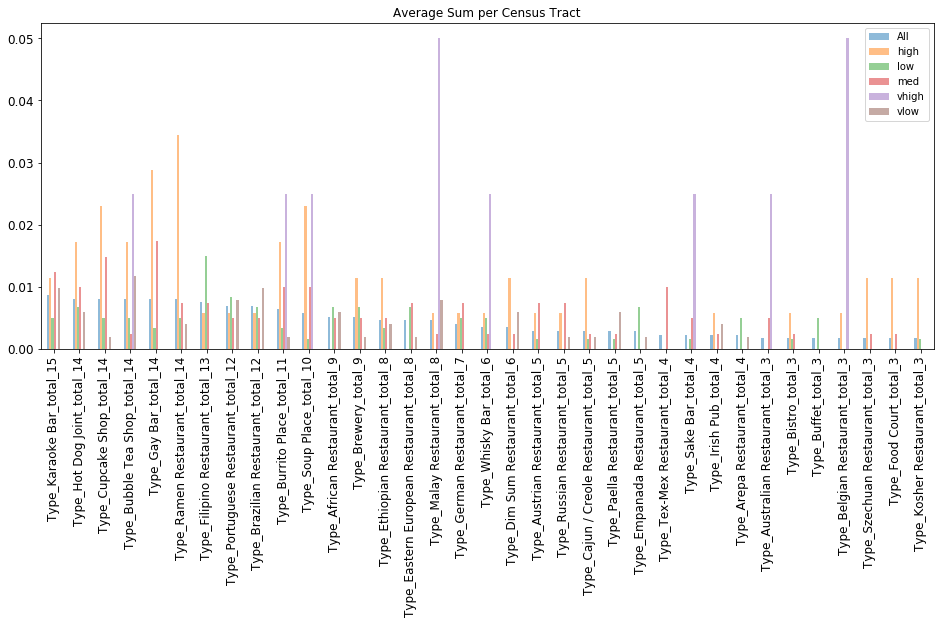

In [107]:
counter = [0]
for fq in list(Foursquare.columns[-3:-2]):
    for i in range(3):
        counter.append((i+1)*(len(pd_plot_CT_sum_mean[fq])//4))
        print(counter)
        print(i)
        print(counter[i],counter[i+1])
        plt.figure()
        pd_plot_CT_sum_mean[fq].iloc[counter[i]:counter[i+1]].plot.bar(alpha=0.5,figsize=(16,6), title='Average Sum per Census Tract', fontsize=12)
        plt.legend()


[0, 35]
0
0 35
[0, 35, 70]
1
35 70
[0, 35, 70, 105]
2
70 105


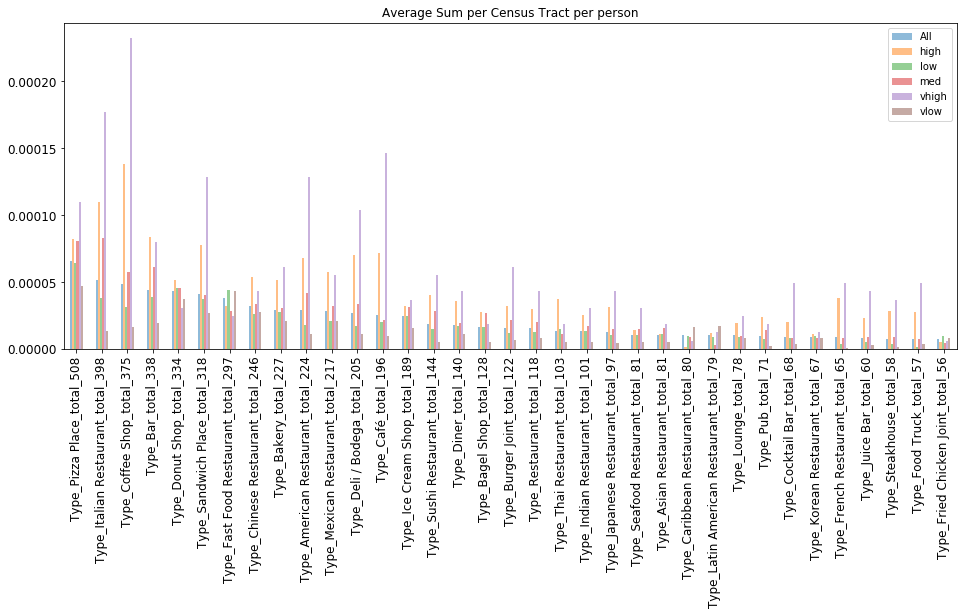

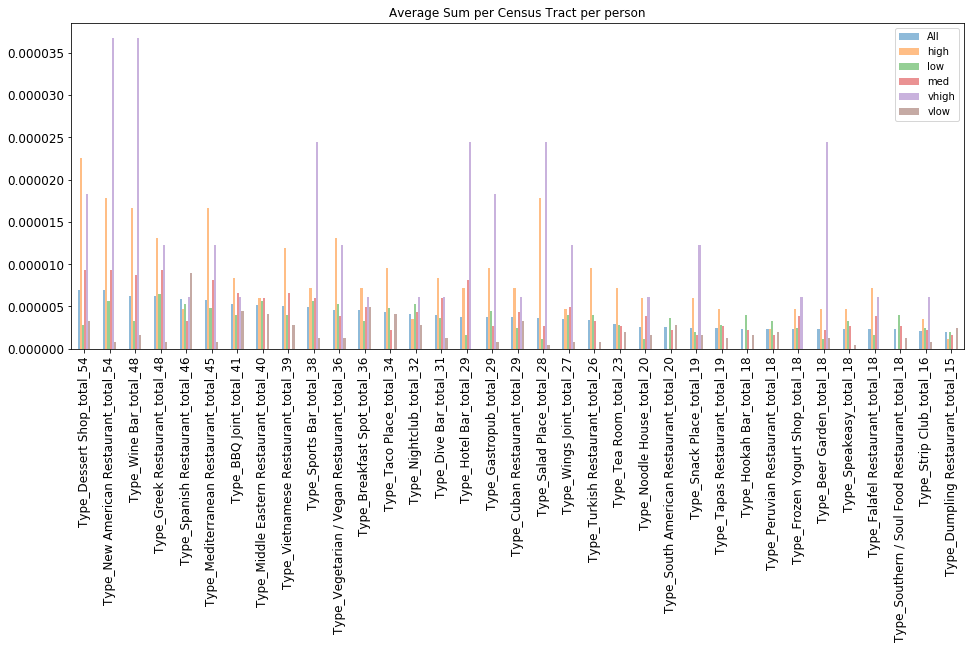

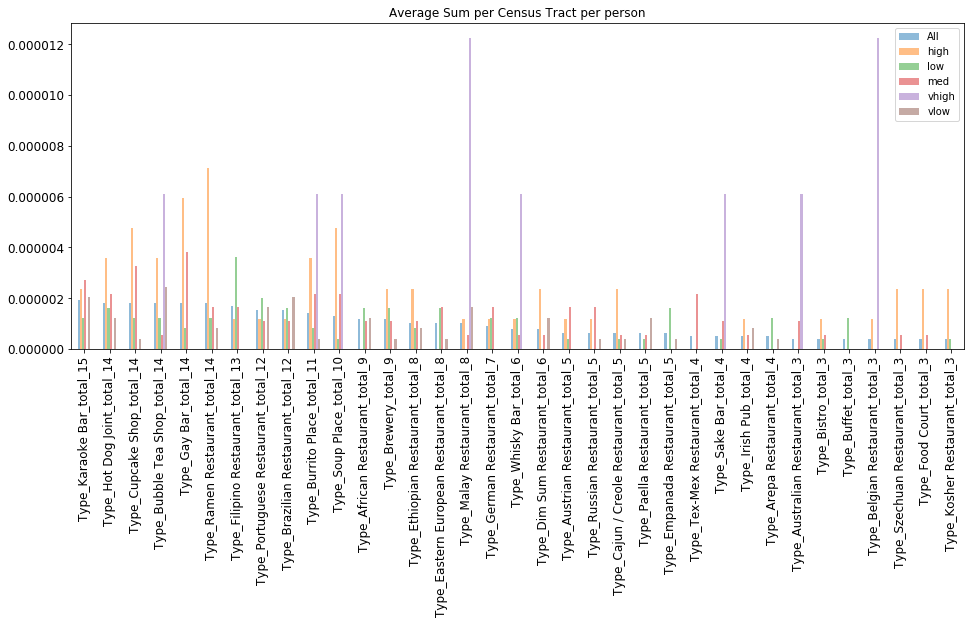

In [108]:
counter = [0]
for fq in list(Foursquare.columns[-3:-2]):
    for i in range(3):
        counter.append((i+1)*(len(pd_plot_CT_sum_mean_pop[fq])//4))
        print(counter)
        print(i)
        print(counter[i],counter[i+1])
        plt.figure()
        pd_plot_CT_sum_mean_pop[fq].iloc[counter[i]:counter[i+1]].plot.bar(alpha=0.5,figsize=(16,6), title='Average Sum per Census Tract per person', fontsize=12)
        plt.legend()


In [111]:
# pd_combined_describe = pdmaps_grouped_CT_sum['All'].describe().copy()
# for i, cluster in enumerate(clusters_groupedbyCT):
#     for column in list(pd_combined_describe.columns):
#         pd_combined_describe[column+'_'+cluster] = pdmaps_grouped_CT_mean[cluster].describe()[column]
# pd_combined_describe

In [112]:
pdmaps_grouped_CT_mean['All']
cols_clusters = clusters_groupedbyCT+['All']
cols_clusters

['low', 'high', 'vlow', 'vhigh', 'med', 'All']

In [113]:
pdmaps_grouped_CT_mean[cols_clusters[5]].columns[:7]

Index(['hinc16', 'pop16', 'Rating', 'Checkins', 'Users', 'Visits', 'Pricing'], dtype='object')

451
hinc16
455


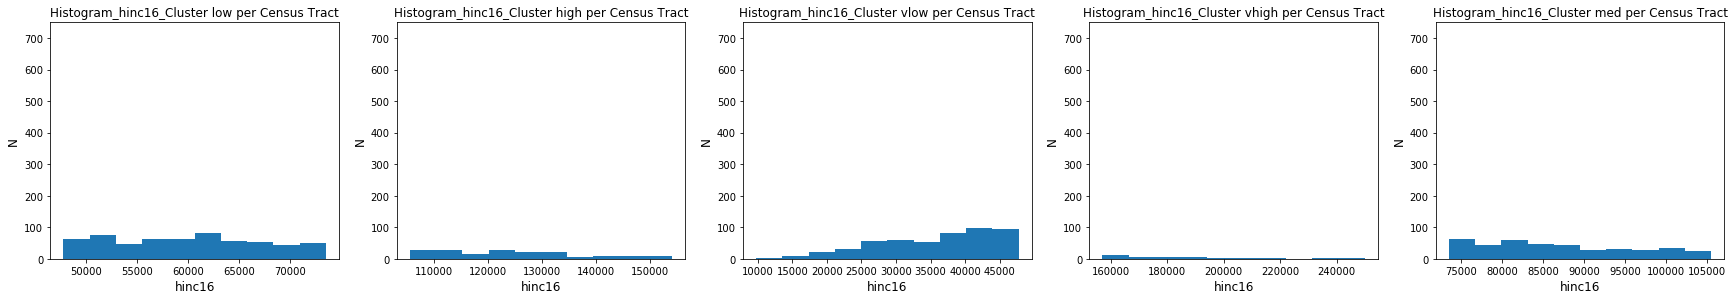

456


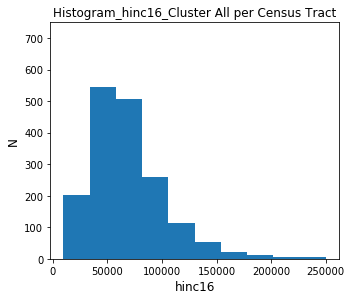

451
pop16
455


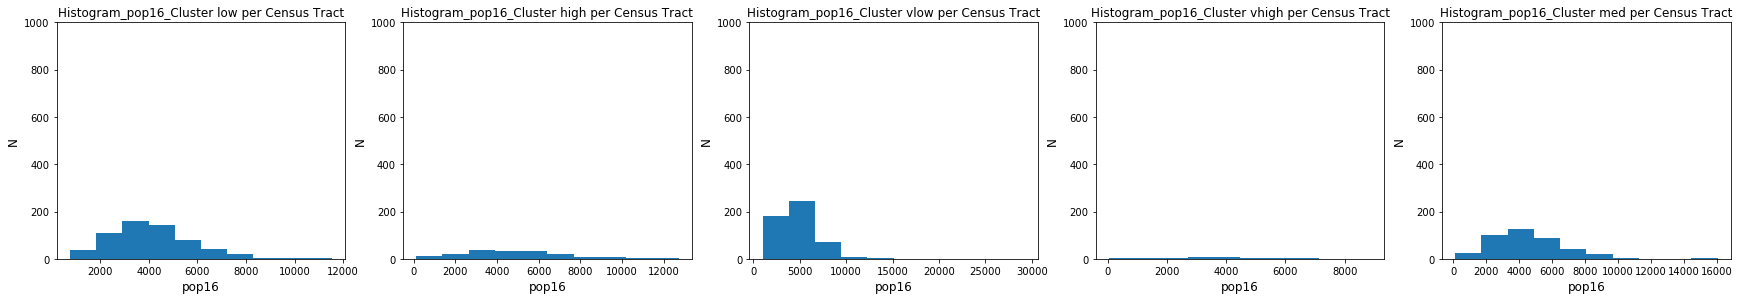

456


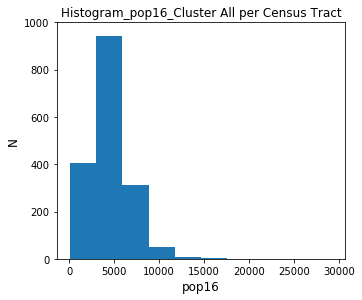

451
Rating
455


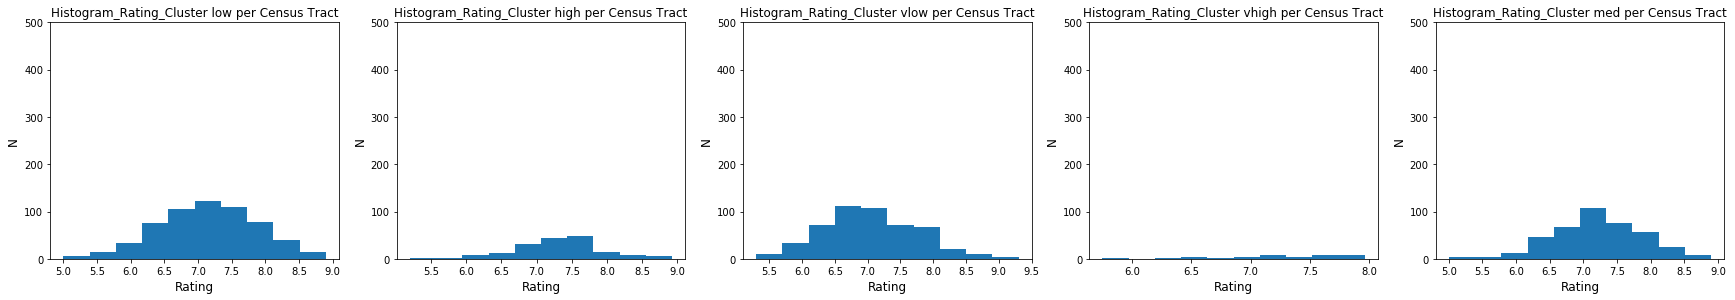

456


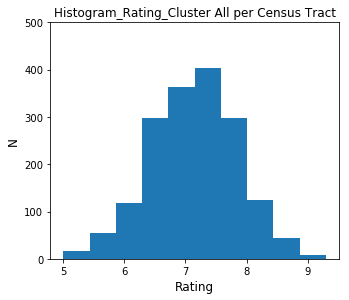

451
Checkins
455


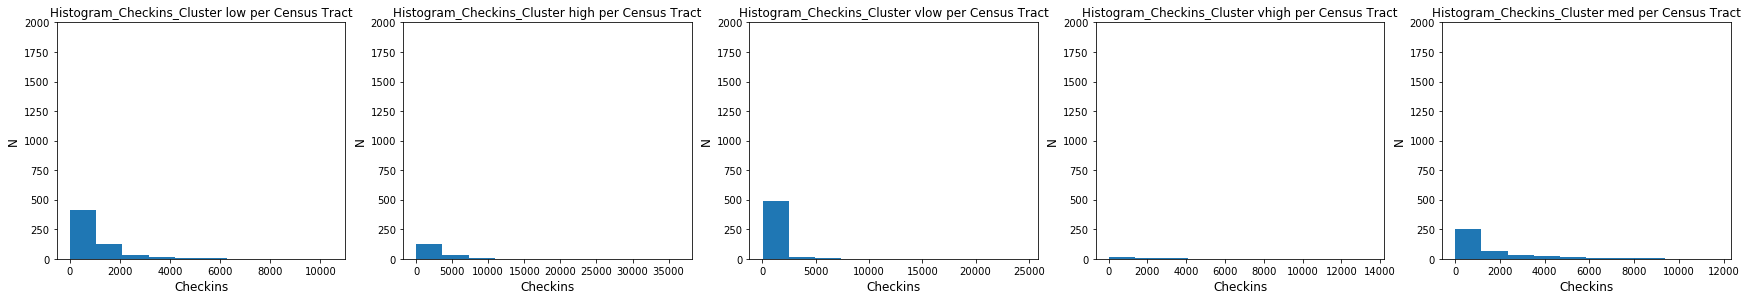

456


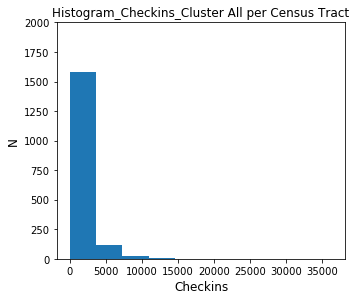

451
Users
455


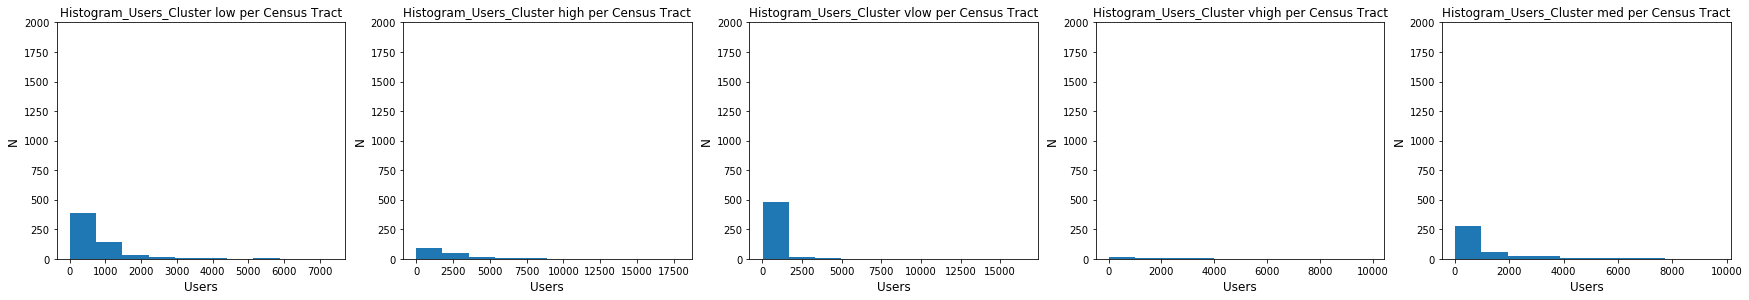

456


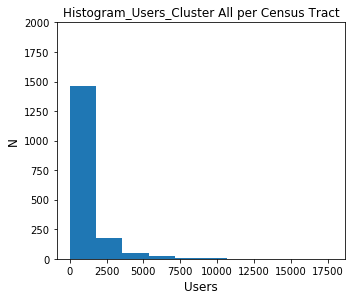

451
Visits
455


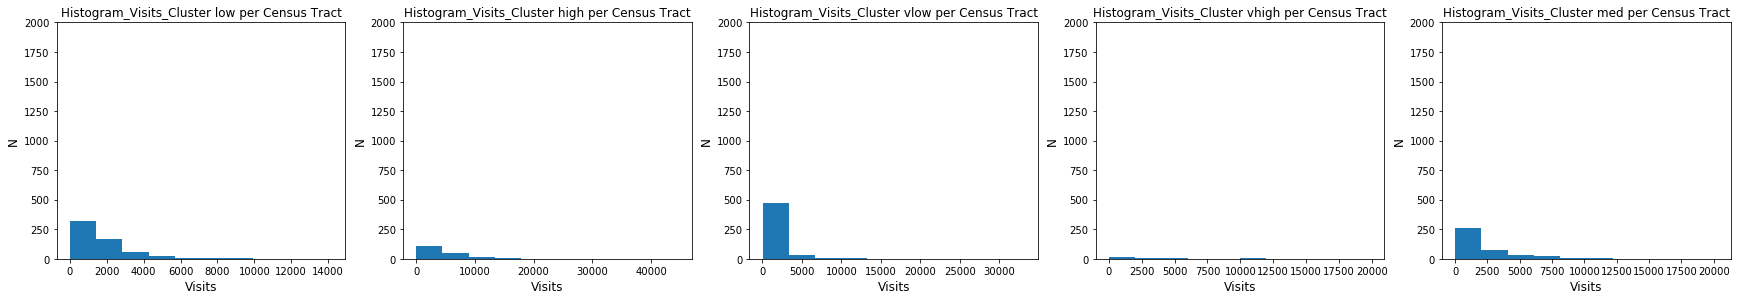

456


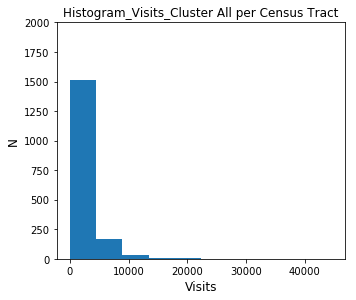

451
Pricing
455


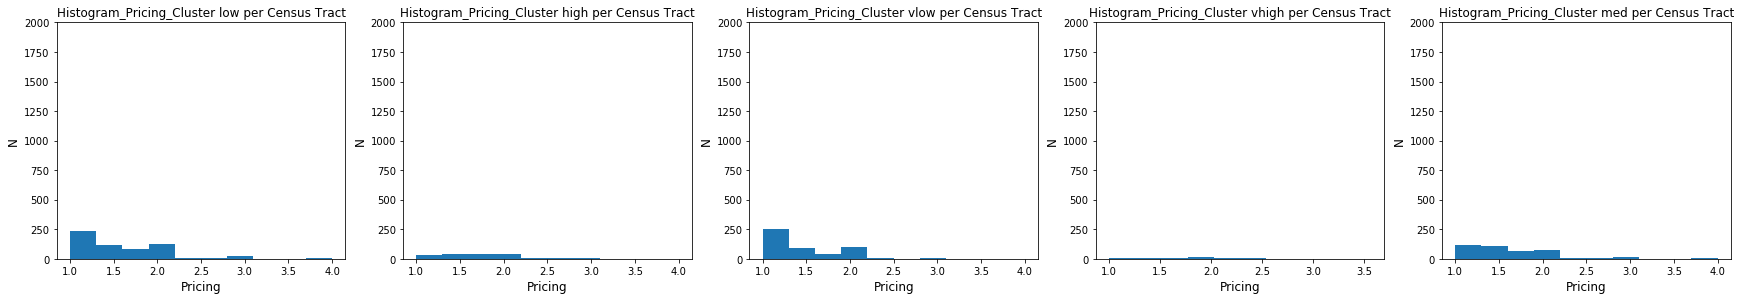

456


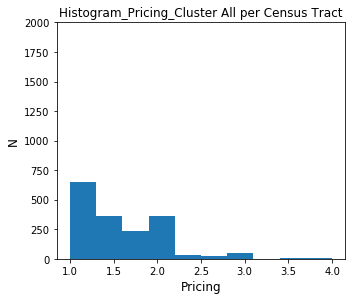

In [114]:
cols_histos = list(X_geoID.columns)[:-3]

cols_histos_values = [750,1000,500,2000,2000,2000,2000,750]
#     plt.ylim((0,400))

for i, column in enumerate(list(pdmaps_grouped_CT_mean[cols_clusters[5]].columns[:7])):
    start = 451
    seq = 0
    print(start + seq)
    print(column)
    plt.subplot(start + seq)
    plt.title('Histogram_'+column +'_Cluster '+cols_clusters[0]+' per Census Tract')
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.ylim((0,cols_histos_values[i]))

    plt.hist(list(pdmaps_grouped_CT_mean[cols_clusters[0]].loc[:,column]))


    seq  += 1 
    plt.subplot(start + seq)
    plt.title('Histogram_'+column +'_Cluster '+cols_clusters[1]+' per Census Tract')
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.ylim((0,cols_histos_values[i]))

    plt.hist(list(pdmaps_grouped_CT_mean[cols_clusters[1]].loc[:,column]))

#     plt.Figure(figsize=(5,5))

    seq  += 1
    plt.subplot(start + seq)
    plt.title('Histogram_'+column +'_Cluster '+cols_clusters[2]+' per Census Tract')
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.ylim((0,cols_histos_values[i]))
    plt.hist(list(pdmaps_grouped_CT_mean[cols_clusters[2]].loc[:,column]))
#     plt.Figure(figsize=(5,5))

    seq  += 1 
    plt.subplot(start + seq)
    plt.title('Histogram_'+column +'_Cluster '+cols_clusters[3]+' per Census Tract')
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.ylim((0,cols_histos_values[i]))

    plt.hist(list(pdmaps_grouped_CT_mean[cols_clusters[3]].loc[:,column]))
#     plt.Figure(figsize=(6,5))

    seq  += 1 
    print(start + seq)
    plt.subplot(start + seq)
    plt.title('Histogram_'+column +'_Cluster '+cols_clusters[4]+' per Census Tract')
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.hist(list(pdmaps_grouped_CT_mean[cols_clusters[4]].loc[:,column]))
    plt.Figure(figsize=(6,1))
    plt.ylim((0,cols_histos_values[i]))
    plt.show()

    seq  += 1 
    print(start + seq)
    plt.subplot(start + seq)
    plt.title('Histogram_'+column +'_Cluster '+cols_clusters[5]+' per Census Tract')
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.hist(list(pdmaps_grouped_CT_mean[cols_clusters[5]].loc[:,column]))
    plt.Figure(figsize=(6,1))
    plt.ylim((0,cols_histos_values[i]))
    plt.show()

#     plt.hist(list(maps.loc[:,column][y == 2]))
#     plt.hist(list(maps.loc[:,column][y == 3]))

#     plt.hist(list(maps.loc[:,column][y == 4]))

#     plt.hist(list(maps.loc[:,column][y == 5]))
#     clusters = ['med','vlow','vhigh','high','low']



451
Category_Consumption
455


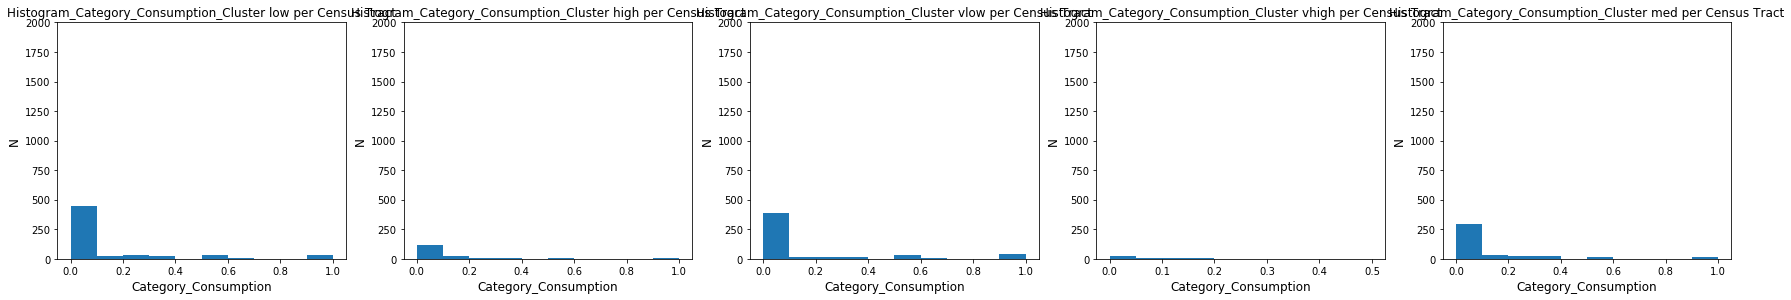

456


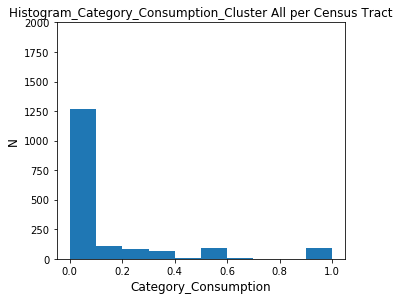

451
Category_Leisure
455


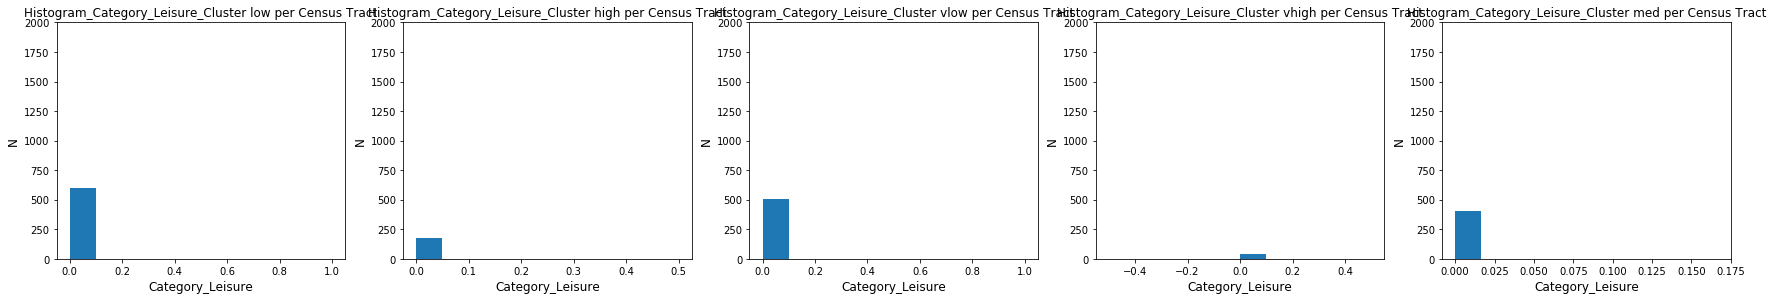

456


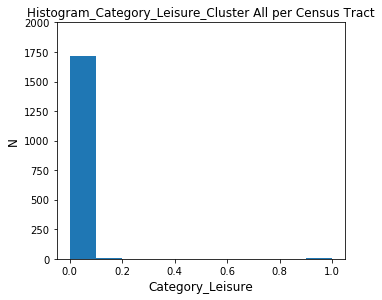

451
Category_Nutrition
455


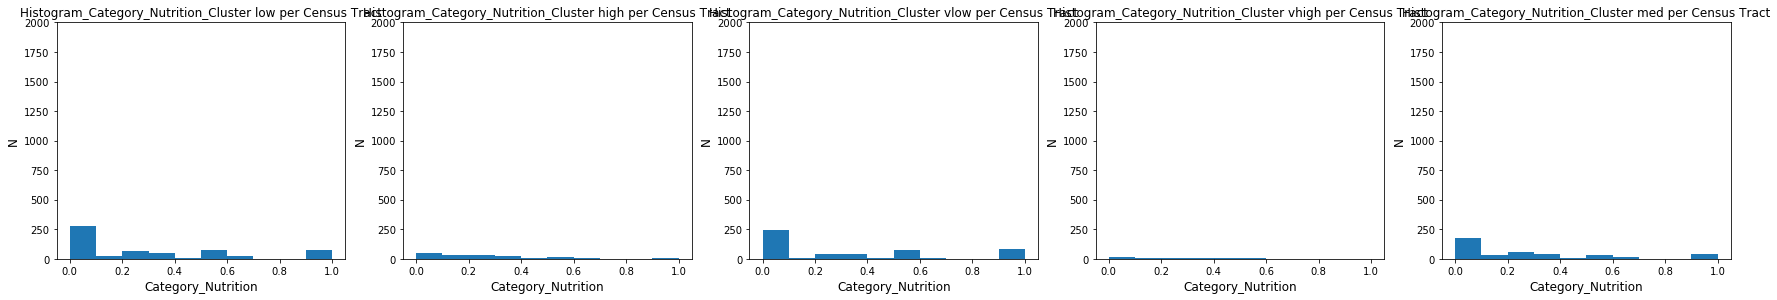

456


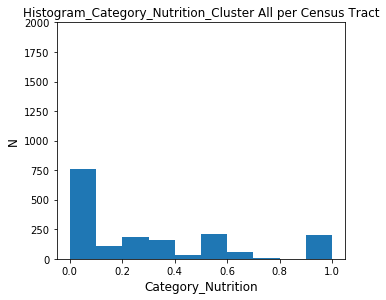

451
Category_Social
455


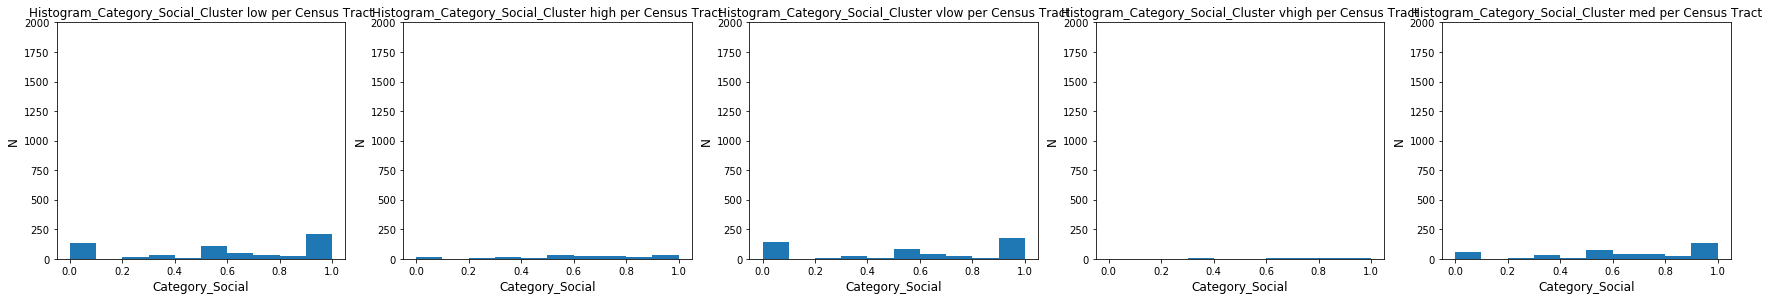

456


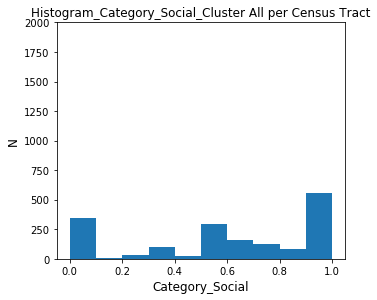

451
Class_Necessary
455


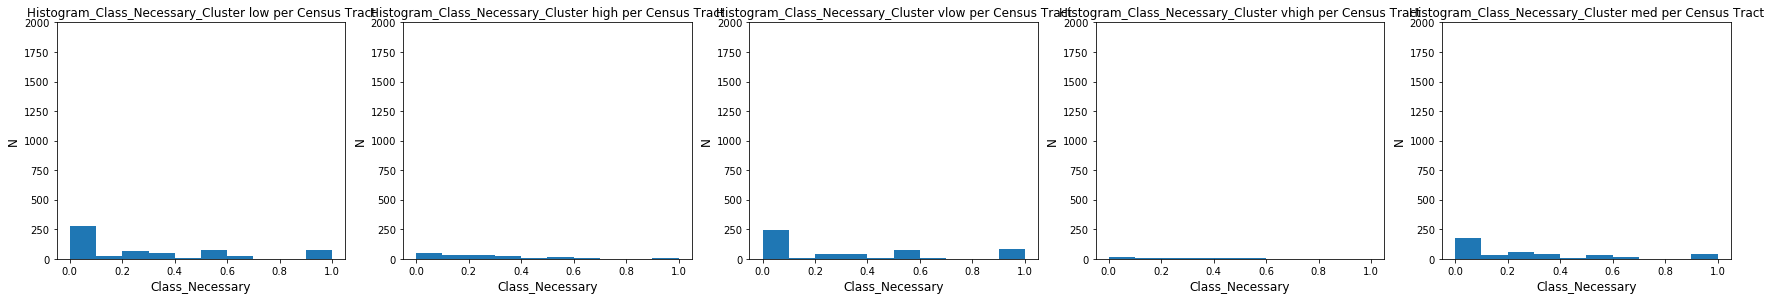

456


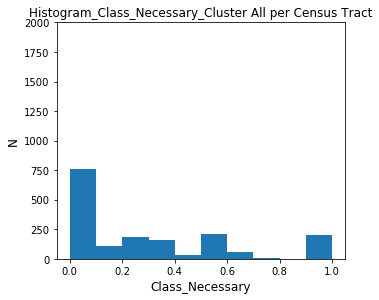

451
Class_Optional
455


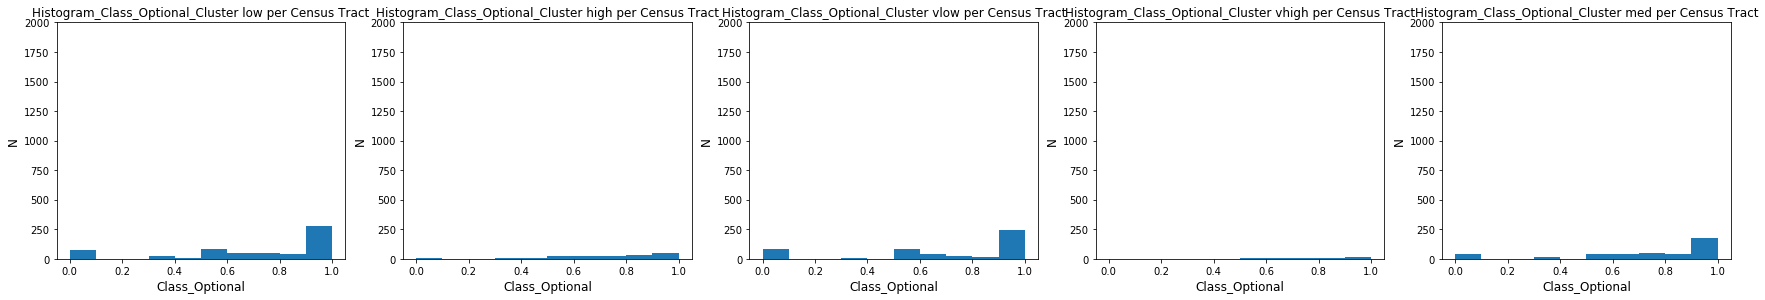

456


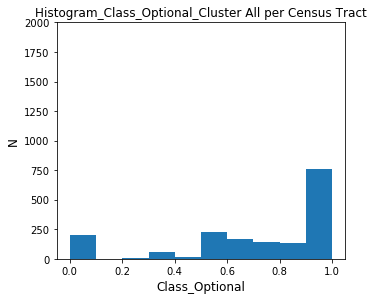

451
clusters
455


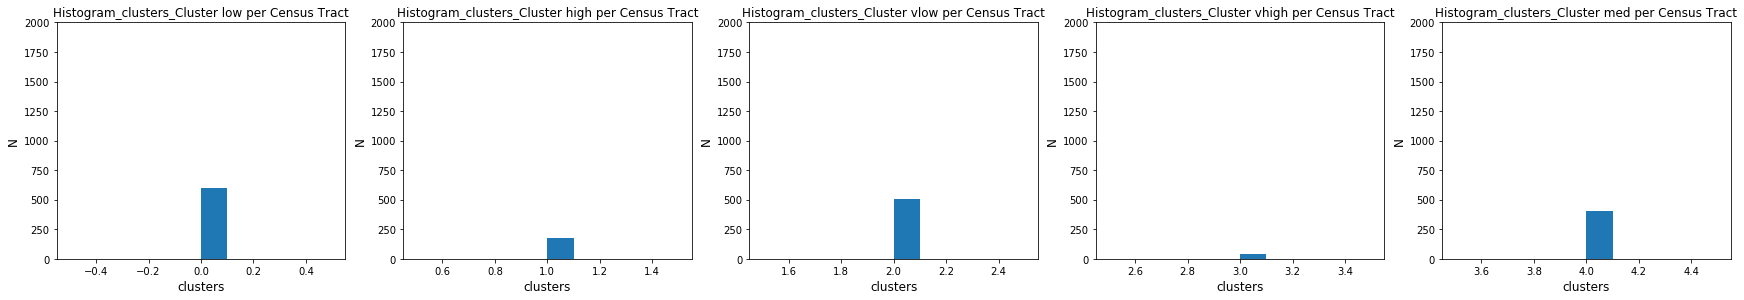

456


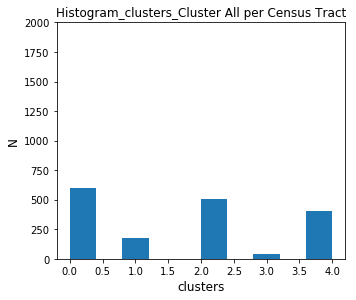

In [115]:
cols_histos = list(X_geoID.columns)[:-3]

cols_histos_values = [2000,2000,2000,2000,2000,2000,2000,2000]
#     plt.ylim((0,400))

for i, column in enumerate(list(pdmaps_grouped_CT_mean[cols_clusters[5]].columns[-7:])):
    start = 451
    seq = 0
    print(start + seq)
    print(column)
    plt.subplot(start + seq)
    plt.title('Histogram_'+column +'_Cluster '+cols_clusters[0]+' per Census Tract')
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.ylim((0,cols_histos_values[i]))

    plt.hist(list(pdmaps_grouped_CT_mean[cols_clusters[0]].loc[:,column]))


    seq  += 1 
    plt.subplot(start + seq)
    plt.title('Histogram_'+column +'_Cluster '+cols_clusters[1]+' per Census Tract')
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.ylim((0,cols_histos_values[i]))

    plt.hist(list(pdmaps_grouped_CT_mean[cols_clusters[1]].loc[:,column]))

#     plt.Figure(figsize=(5,5))

    seq  += 1
    plt.subplot(start + seq)
    plt.title('Histogram_'+column +'_Cluster '+cols_clusters[2]+' per Census Tract')
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.ylim((0,cols_histos_values[i]))
    plt.hist(list(pdmaps_grouped_CT_mean[cols_clusters[2]].loc[:,column]))
#     plt.Figure(figsize=(5,5))

    seq  += 1 
    plt.subplot(start + seq)
    plt.title('Histogram_'+column +'_Cluster '+cols_clusters[3]+' per Census Tract')
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.ylim((0,cols_histos_values[i]))

    plt.hist(list(pdmaps_grouped_CT_mean[cols_clusters[3]].loc[:,column]))
#     plt.Figure(figsize=(6,5))

    seq  += 1 
    print(start + seq)
    plt.subplot(start + seq)
    plt.title('Histogram_'+column +'_Cluster '+cols_clusters[4]+' per Census Tract')
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.hist(list(pdmaps_grouped_CT_mean[cols_clusters[4]].loc[:,column]))
    plt.Figure(figsize=(6,1))
    plt.ylim((0,cols_histos_values[i]))
    plt.show()

    seq  += 1 
    print(start + seq)
    plt.subplot(start + seq)
    plt.title('Histogram_'+column +'_Cluster '+cols_clusters[5]+' per Census Tract')
    plt.ylabel('N', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.hist(list(pdmaps_grouped_CT_mean[cols_clusters[5]].loc[:,column]))
    plt.Figure(figsize=(6,1))
    plt.ylim((0,cols_histos_values[i]))
    plt.show()

#     plt.hist(list(maps.loc[:,column][y == 2]))
#     plt.hist(list(maps.loc[:,column][y == 3]))

#     plt.hist(list(maps.loc[:,column][y == 4]))

#     plt.hist(list(maps.loc[:,column][y == 5]))
#     clusters = ['med','vlow','vhigh','high','low']



# Numerical values

In [116]:
for fq in list(Foursquare.columns[:-3]):
    print(fq)
pdmaps_0.describe().loc['mean'][fq]/pdmaps_0.describe().loc['mean']['pop16']

Rating
Checkins
Users
Visits
Pricing


0.00034353951352279836

In [120]:
foursquare_groupbied_mean = {}
foursquare_clusters_mean = {}
for fq in list(Foursquare.columns[:-3]):
    print(fq)
    name = fq+'_total_'+str(X_geoID.describe().loc['count'][fq])
    foursquare_groupbied_mean[name] = {}
    
    foursquare_groupbied_mean[name]['All'] = X_geoID.describe().loc['mean'][fq]/X_geoID.describe().loc['mean']['pop16']
    foursquare_groupbied_mean[name][clusters_groupedbyCT[0]] = pdmaps_0.describe().loc['mean'][fq]/pdmaps_0.describe().loc['mean']['pop16']
    foursquare_groupbied_mean[name][clusters_groupedbyCT[1]] = pdmaps_1.describe().loc['mean'][fq]/pdmaps_1.describe().loc['mean']['pop16']
    foursquare_groupbied_mean[name][clusters_groupedbyCT[2]] = pdmaps_2.describe().loc['mean'][fq]/pdmaps_2.describe().loc['mean']['pop16']
    foursquare_groupbied_mean[name][clusters_groupedbyCT[3]] = pdmaps_3.describe().loc['mean'][fq]/pdmaps_3.describe().loc['mean']['pop16']
    foursquare_groupbied_mean[name][clusters_groupedbyCT[4]] = pdmaps_4.describe().loc['mean'][fq]/pdmaps_4.describe().loc['mean']['pop16']
foursquare_groupbied_mean

Rating
Checkins
Users
Visits
Pricing


{'Checkins_total_7294.0': {'All': 0.51406660841913421,
  'high': 0.21888197901201484,
  'low': 0.63634138613431557,
  'med': 0.4220198238669155,
  'vhigh': 0.81676292835215991,
  'vlow': 1.0447091533449921},
 'Pricing_total_7294.0': {'All': 0.00033839132983155959,
  'high': 0.00030320223120323362,
  'low': 0.00034353951352279836,
  'med': 0.00032871891575434153,
  'vhigh': 0.00037105707682412833,
  'vlow': 0.00048974145892823745},
 'Rating_total_7294.0': {'All': 0.0015116642746112803,
  'high': 0.0014530282202713778,
  'low': 0.001504463854094715,
  'med': 0.0015177535476829543,
  'vhigh': 0.0015272069818638065,
  'vlow': 0.0018923494286028283},
 'Users_total_7294.0': {'All': 0.41109676652235638,
  'high': 0.18809890399120571,
  'low': 0.49089238209434843,
  'med': 0.3248057097468347,
  'vhigh': 0.68078153202651681,
  'vlow': 0.86127783958460669},
 'Visits_total_7294.0': {'All': 0.77236458479858872,
  'high': 0.38160006928963824,
  'low': 0.92632915847548647,
  'med': 0.636416455537693

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


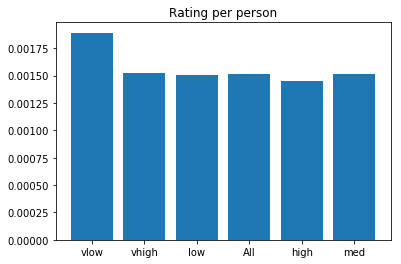

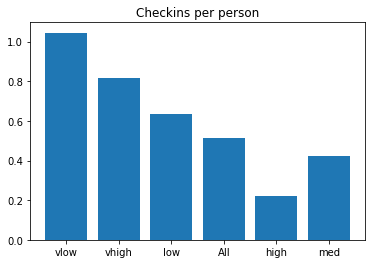

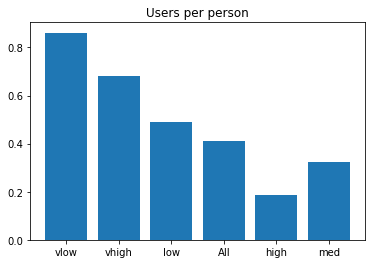

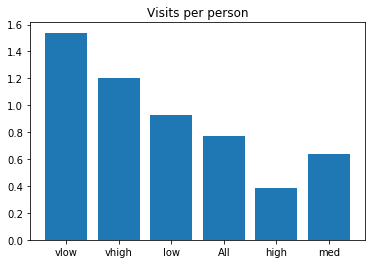

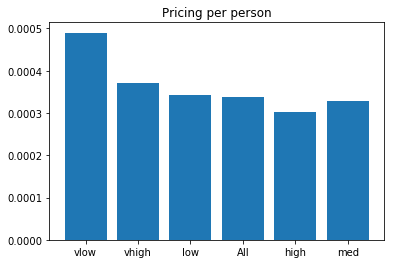

In [121]:
for fq in list(Foursquare.columns[:-3]):
    name  = fq+'_total_'+str(X_geoID.describe().loc['count'][fq])

    D = foursquare_groupbied_mean[name]
    plt.figure(figsize=(6,4))
    plt.bar(range(len(D)), D.values(), align='center',)
    plt.title(fq+' per person')
    plt.xticks(range(len(D)), list(D.keys()))
#     .plot.bar(alpha=0.5,figsize=(16,6), title=fq, fontsize=12)
    plt.legend()
    plt.show()

In [123]:
foursquare_groupbied_mean = {}
foursquare_clusters_mean = {}
for fq in list(Foursquare.columns[:-3]):
    print(fq)
    name = fq+'_total_'+str(X_geoID.describe().loc['count'][fq])
    foursquare_groupbied_mean[name] = {}
    
    foursquare_groupbied_mean[name]['All'] = X_geoID.describe().loc['mean'][fq]
    foursquare_groupbied_mean[name][clusters_groupedbyCT[0]] = pdmaps_0.describe().loc['mean'][fq]
    foursquare_groupbied_mean[name][clusters_groupedbyCT[1]] = pdmaps_1.describe().loc['mean'][fq]
    foursquare_groupbied_mean[name][clusters_groupedbyCT[2]] = pdmaps_2.describe().loc['mean'][fq]
    foursquare_groupbied_mean[name][clusters_groupedbyCT[3]] = pdmaps_3.describe().loc['mean'][fq]
    foursquare_groupbied_mean[name][clusters_groupedbyCT[4]] = pdmaps_4.describe().loc['mean'][fq]
foursquare_groupbied_mean

Rating
Checkins
Users
Visits
Pricing


{'Checkins_total_7294.0': {'All': 2477.6238003838771,
  'high': 1068.667448680352,
  'low': 3119.3610206297503,
  'med': 2023.3008418254319,
  'vhigh': 3949.2262001627341,
  'vlow': 4151.946360153257},
 'Pricing_total_7294.0': {'All': 1.6309295311214698,
  'high': 1.4803519061583579,
  'low': 1.6840390879478828,
  'med': 1.5759858218874612,
  'vhigh': 1.7941415785191213,
  'vlow': 1.946360153256705},
 'Rating_total_7294.0': {'All': 7.2857005758157527,
  'high': 7.0942521994134999,
  'low': 7.3749185667752437,
  'med': 7.2766061143110203,
  'vhigh': 7.3843775427176546,
  'vlow': 7.5206896551724105},
 'Users_total_7294.0': {'All': 1981.3446668494653,
  'high': 918.37243401759531,
  'low': 2406.3664495114008,
  'med': 1557.2246344705361,
  'vhigh': 3291.726606997559,
  'vlow': 3422.9425287356321},
 'Visits_total_7294.0': {'All': 3722.5309843707155,
  'high': 1863.1208211143694,
  'low': 4540.8881650380026,
  'med': 3051.1883030571557,
  'vhigh': 5799.6753458096009,
  'vlow': 6118.27969348

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


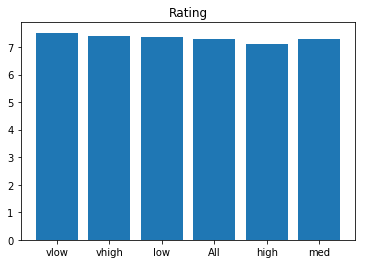

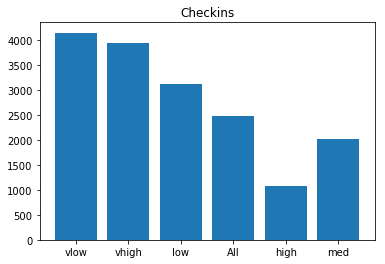

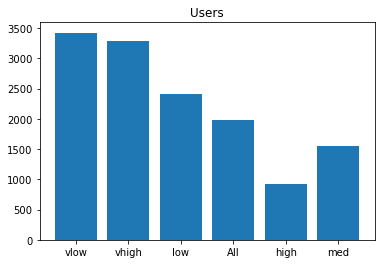

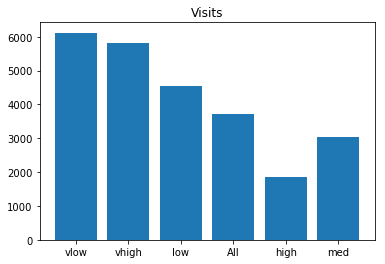

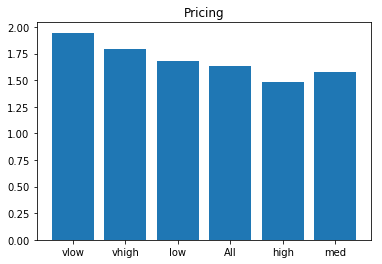

In [124]:
for fq in list(Foursquare.columns[:-3]):
    name  = fq+'_total_'+str(X_geoID.describe().loc['count'][fq])

    D = foursquare_groupbied_mean[name]
    plt.figure(figsize=(6,4))
    plt.bar(range(len(D)), D.values(), align='center',)
    plt.title(fq)
    plt.xticks(range(len(D)), list(D.keys()))
#     .plot.bar(alpha=0.5,figsize=(16,6), title=fq, fontsize=12)
    plt.legend()
    plt.show()